# **Xử lý ảnh**

In [1]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Sử dụng tqdm.notebook nếu chạy trong Kaggle/Jupyter

TARGET_SIZE = 512

base_input_dir = "/kaggle/input/btxrd-data/BTXRD/BTXRD" # Đường dẫn gốc chứa ảnh và annotation
image_dir = os.path.join(base_input_dir, "images")      # Thư mục chứa ảnh gốc
annotation_dir = os.path.join(base_input_dir, "Annotations") # Thư mục chứa annotation gốc

output_dir = "/kaggle/working/btxrd-v2.2"
output_image_dir = os.path.join(output_dir, "images")
output_anno_dir = os.path.join(output_dir, "Annotations")

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_anno_dir, exist_ok=True)

MAX_VISUALIZATIONS = 5 # Số lượng ảnh tối đa để trực quan hóa
visualized_count = 0


def get_bounding_box(points):
    if not points:
        return None
    points_array = np.array(points)
    xmin = int(np.min(points_array[:, 0]))
    ymin = int(np.min(points_array[:, 1]))
    xmax = int(np.max(points_array[:, 0]))
    ymax = int(np.max(points_array[:, 1]))
    # Đảm bảo tọa độ không âm
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    return (xmin, ymin, xmax, ymax)

try:
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_images = len(image_files)
    if total_images == 0:
        print(f"Không tìm thấy file ảnh nào trong: {image_dir}")
        exit()
    print(f"Tìm thấy {total_images} ảnh để xử lý.")
except FileNotFoundError:
    print(f"Không tìm thấy thư mục ảnh: {image_dir}")
    exit()

print(f"Bắt đầu xử lý ảnh và lưu vào: {output_dir}")
# Sử dụng tqdm để hiển thị thanh tiến trình
for file in tqdm(image_files, desc="Processing Images"):
    img_path = os.path.join(image_dir, file)
    anno_filename = file.rsplit('.', 1)[0] + '.json'
    anno_path = os.path.join(annotation_dir, anno_filename)

    # Đọc ảnh gốc
    img_orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_orig is None:
        # print(f"Không thể đọc ảnh: {file}") # Có thể bỏ comment nếu muốn thấy lỗi cụ thể
        continue
    orig_height, orig_width = img_orig.shape[:2]

    # Đọc annotation gốc 
    annotation_orig = None
    has_annotation = os.path.exists(anno_path)
    if has_annotation:
        try:
            with open(anno_path, "r", encoding="utf-8") as f:
                annotation_orig = json.load(f)
        except Exception as e:
            # print(f"Lỗi khi đọc annotation {anno_filename}: {e}") # Bỏ comment nếu cần debug
            has_annotation = False # Coi như không có nếu đọc lỗi

    img_to_draw_orig = None
    img_to_draw_padded = None
    original_bboxes = []
    transformed_bboxes = []

    should_visualize = has_annotation and (visualized_count < MAX_VISUALIZATIONS)

    if should_visualize:
        img_to_draw_orig = cv2.cvtColor(img_orig, cv2.COLOR_GRAY2BGR) # Chuyển sang BGR để vẽ màu
        if annotation_orig and "shapes" in annotation_orig:
             for shape in annotation_orig["shapes"]:
                if shape.get("shape_type") == "rectangle" and "points" in shape and len(shape["points"]) == 2:
                     # LabelMe rectangle format uses [top-left, bottom-right]
                     p1 = shape["points"][0]
                     p2 = shape["points"][1]
                     xmin = int(min(p1[0], p2[0]))
                     ymin = int(min(p1[1], p2[1]))
                     xmax = int(max(p1[0], p2[0]))
                     ymax = int(max(p1[1], p2[1]))
                     bbox = (max(0, xmin), max(0, ymin), xmax, ymax)
                     original_bboxes.append(bbox)
                     cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Vẽ màu đỏ (BGR)
                elif shape.get("shape_type") in ["polygon", "linestrip", "point"] and "points" in shape and shape["points"]:
                     # Lấy bounding box bao quanh các loại shape khác
                     bbox = get_bounding_box(shape["points"])
                     if bbox:
                        original_bboxes.append(bbox)
                        cv2.rectangle(img_to_draw_orig, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2) # Red

    # Resize ảnh với padding để giữ tỉ lệ
    # Tính tỉ lệ resize để cạnh dài nhất bằng TARGET_SIZE
    scale = TARGET_SIZE / max(orig_height, orig_width)
    new_width = int(orig_width * scale)
    new_height = int(orig_height * scale)

    # Đảm bảo kích thước mới không lớn hơn TARGET_SIZE
    new_width = min(new_width, TARGET_SIZE)
    new_height = min(new_height, TARGET_SIZE)

    # Resize ảnh
    img_resized = cv2.resize(img_orig, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Tính toán padding
    pad_h = TARGET_SIZE - new_height
    pad_w = TARGET_SIZE - new_width
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left

    # Thêm padding
    # Sử dụng giá trị 0 (màu đen) cho padding vì ảnh là grayscale
    padded_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Lưu ảnh đã xử lý
    output_img_path = os.path.join(output_image_dir, file)
    try:
        # Đảm bảo kích thước cuối cùng đúng là TARGET_SIZE x TARGET_SIZE
        if padded_img.shape[0] != TARGET_SIZE or padded_img.shape[1] != TARGET_SIZE:
             # Nếu có sai lệch nhỏ do làm tròn, resize lại lần cuối
             padded_img = cv2.resize(padded_img, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
             # print(f"Final resize needed for {file}. Original: ({orig_width}x{orig_height}), Resized: ({new_width}x{new_height}), Padded: {padded_img.shape[:2]}")


        cv2.imwrite(output_img_path, padded_img)
    except Exception as e:
        # print(f"Lỗi khi lưu ảnh {output_img_path}: {e}") # Bỏ comment nếu cần debug
        continue # Bỏ qua ảnh này nếu không lưu được

    # Xử lý và lưu annotation
    if has_annotation and annotation_orig:
        # Tạo bản sao sâu để không ảnh hưởng annotation gốc
        annotation_new = json.loads(json.dumps(annotation_orig))

        if "shapes" in annotation_new:
            new_shapes = [] # Tạo list mới để chứa các shape đã chuyển đổi
            for shape in annotation_new["shapes"]:
                if "points" in shape and shape["points"]:
                    original_points = shape["points"]
                    new_points_transformed = []
                    valid_shape = True
                    for x, y in original_points:
                        # Áp dụng tỉ lệ resize
                        new_x = x * scale
                        new_y = y * scale
                        # Áp dụng padding offset
                        new_x += left
                        new_y += top

                        # Kiểm tra xem điểm có nằm trong ảnh mới không
                        # new_x = max(0, min(TARGET_SIZE - 1, new_x))
                        # new_y = max(0, min(TARGET_SIZE - 1, new_y))
                        new_points_transformed.append([new_x, new_y])

                    # Cập nhật điểm trong shape
                    shape["points"] = new_points_transformed
                    new_shapes.append(shape) # Thêm shape đã chuyển đổi vào list mới

                    # Tính bbox mới để trực quan hóa
                    if should_visualize:
                        new_bbox = get_bounding_box(new_points_transformed)
                        if new_bbox:
                            # Đảm bảo bbox không vượt ra ngoài TARGET_SIZE
                            xmin = max(0, min(TARGET_SIZE - 1, new_bbox[0]))
                            ymin = max(0, min(TARGET_SIZE - 1, new_bbox[1]))
                            xmax = max(0, min(TARGET_SIZE - 1, new_bbox[2]))
                            ymax = max(0, min(TARGET_SIZE - 1, new_bbox[3]))
                            # Chỉ thêm vào nếu bbox hợp lệ
                            if xmax > xmin and ymax > ymin:
                                transformed_bboxes.append((xmin, ymin, xmax, ymax))

            # Cập nhật lại danh sách shapes và kích thước ảnh trong annotation
            annotation_new["shapes"] = new_shapes
            annotation_new["imagePath"] = file # Cập nhật tên file ảnh mới
            annotation_new["imageWidth"] = TARGET_SIZE
            annotation_new["imageHeight"] = TARGET_SIZE
            
            if "imageData" in annotation_new:
                annotation_new["imageData"] = None

            # Lưu file annotation mới
            output_annotation_path = os.path.join(output_anno_dir, anno_filename)
            try:
                with open(output_annotation_path, "w", encoding="utf-8") as f:
                    json.dump(annotation_new, f, indent=4, ensure_ascii=False)
            except Exception as e:
                # print(f"Lỗi khi lưu annotation {anno_filename}: {e}") # Bỏ comment nếu cần debug
                pass # Bỏ qua nếu lưu lỗi

            if should_visualize and img_to_draw_orig is not None:
                # Chuyển ảnh đã padding sang BGR để vẽ màu
                img_to_draw_padded = cv2.cvtColor(padded_img, cv2.COLOR_GRAY2BGR)
                # Vẽ các bounding box đã biến đổi
                for bbox in transformed_bboxes:
                     # Đảm bảo tọa độ là số nguyên để vẽ
                     pt1 = (int(bbox[0]), int(bbox[1]))
                     pt2 = (int(bbox[2]), int(bbox[3]))
                     cv2.rectangle(img_to_draw_padded, pt1, pt2, (0, 255, 0), 2) # Vẽ màu xanh lá (BGR)

                # Hiển thị ảnh gốc và ảnh đã xử lý
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                # Ảnh gốc với bbox gốc (màu đỏ)
                axes[0].imshow(cv2.cvtColor(img_to_draw_orig, cv2.COLOR_BGR2RGB)) # Chuyển BGR sang RGB cho matplotlib
                axes[0].set_title(f'Original: {file}\nSize: {orig_width}x{orig_height}')
                axes[0].axis('off')

                # Ảnh đã xử lý với bbox mới (màu xanh)
                axes[1].imshow(cv2.cvtColor(img_to_draw_padded, cv2.COLOR_BGR2RGB)) # Chuyển BGR sang RGB
                axes[1].set_title(f'Processed (Resized & Padded)\nSize: {TARGET_SIZE}x{TARGET_SIZE}')
                axes[1].axis('off')

                plt.suptitle(f"Visualization {visualized_count + 1}/{MAX_VISUALIZATIONS}")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề không bị che
                plt.show()

                visualized_count += 1

print(f"Xử lý {total_images} ảnh.")
if visualized_count > 0:
    print(f"Hiển thị {visualized_count} ảnh trực quan hóa.")

Tìm thấy 3746 ảnh để xử lý.
Bắt đầu xử lý ảnh và lưu vào: /kaggle/working/btxrd-v2.2


Processing Images:   0%|          | 0/3746 [00:00<?, ?it/s]

------------------------------
Hoàn tất xử lý 3746 ảnh.
Ảnh đã xử lý được lưu tại: /kaggle/working/btxrd-v2.2/images
Annotation đã xử lý được lưu tại: /kaggle/working/btxrd-v2.2/Annotations
Đã hiển thị 5 ảnh trực quan hóa.


# **Chia tập dữ liệu**

In [9]:
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import shutil 


In [10]:
image_dir = "/kaggle/working/btxrd-v2.2/images"
annotation_dir = "/kaggle/working/btxrd-v2.2/Annotations"
excel_path = "/kaggle/input/btxrd-data/classification.xlsx"

output_split_dir = "/kaggle/working/btxrd-v2.1"

ANNOTATION_EXTENSION = ".json"

VAL_SIZE = 0.20   # 20% cho tập validation
TRAIN_SIZE = 0.70 # 70% cho tập train
TEST_SIZE = 1.0 - VAL_SIZE - TRAIN_SIZE

RANDOM_STATE = 42

In [11]:
# Đọc Dữ liệu Phân loại từ Excel
try:
    df_classification = pd.read_excel(excel_path)
    required_columns = ['image_id', 'tumor_type', 'image_filename']
    if not all(col in df_classification.columns for col in required_columns):
        missing = [col for col in required_columns if col not in df_classification.columns]
        raise ValueError(f"File Excel thiếu các cột bắt buộc: {missing}")

    df_classification['image_id'] = df_classification['image_id'].astype(str).str.strip()
    df_classification['image_filename'] = df_classification['image_filename'].astype(str).str.strip()

    print(f"Đọc thành công {len(df_classification)} dòng")
    print(df_classification['tumor_type'].value_counts())
except FileNotFoundError:
    print(f"Không tìm thấy file Excel tại {excel_path}")
    exit()
except ValueError as ve:
    print(f"Lỗi dữ liệu trong file Excel: {ve}")
    exit()
except Exception as e:
    print(f"không xác định khi đọc file Excel: {e}")
    exit()

try:
    all_image_files = glob.glob(os.path.join(image_dir, "*.*"))
    annotation_files = glob.glob(os.path.join(annotation_dir, f"*{ANNOTATION_EXTENSION}"))

    image_basenames_actual = set(os.path.splitext(os.path.basename(f))[0] for f in all_image_files)
    annotation_basenames_actual = set(os.path.splitext(os.path.basename(f))[0] for f in annotation_files)

    print(f"Tìm thấy {len(all_image_files)} tệp")
    print(f"Tìm thấy {len(annotation_files)} tệp annotation")
except Exception as e:
    print(f"Lỗi khi quét thư mục ảnh hoặc annotation: {e}")
    exit()

Đọc thành công 3746 dòng
tumor_type
osteochondroma              754
osteosarcoma                297
multiple osteochondromas    263
simple bone cyst            206
other bt                    115
giant cell tumor             93
synovial osteochondroma      50
other mt                     45
osteofibroma                 44
Name: count, dtype: int64
Tìm thấy 3746 tệp
Tìm thấy 1867 tệp annotation


In [12]:
excel_image_ids = set(df_classification['image_id'])
valid_ids = list(excel_image_ids.intersection(image_basenames_actual).intersection(annotation_basenames_actual))

if not valid_ids:
    print("Không tìm thấy dữ liệu hợp lệ nào.")
    exit()
df_filtered = df_classification[df_classification['image_id'].isin(valid_ids)].copy()
df_filtered = df_filtered.drop_duplicates(subset=['image_id'])
filename_map = pd.Series(df_filtered.image_filename.values, index=df_filtered.image_id).to_dict()


In [13]:
# Chuẩn bị dữ liệu (X=IDs, y=Labels) cho việc chia
X = df_filtered['image_id'].tolist() # Danh sách ID ảnh 
y = df_filtered['tumor_type'].tolist() # Danh sách nhãn tương ứng

# Chia Lần 1 (Train+Val / Test)
X_train_val, X_test, y_train_val, y_test = [], [], [], []
if len(X) < 2:
    print("Không đủ mẫu dữ liệu (< 2) để thực hiện chia.")
    exit()
if TEST_SIZE <= 0 or TEST_SIZE >= 1:
     print(f"Tỷ lệ Test ({TEST_SIZE:.2f}) không hợp lệ. Toàn bộ dữ liệu sẽ là Train+Val.")
     X_train_val, y_train_val = X, y
else:
    try:
        unique_classes_total, counts_total = np.unique(y, return_counts=True)
        stratify_option_1 = y
        if len(unique_classes_total) < 2:
            print("Chỉ có 1 lớp. Chia ngẫu nhiên cho Test.")
            stratify_option_1 = None
        elif np.any(counts_total < 2):
             print(f"Có lớp < 2 mẫu. Chia ngẫu nhiên cho Test.")
             stratify_option_1 = None

        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_option_1
        )
        print(f"Chia lần 1: {len(X_train_val)} Train+Val, {len(X_test)} Test.")
        print("Phân phối 'tumor_type' trong Test:", sorted(Counter(y_test).items()))
    except ValueError as e:
         print(f"Lỗi khi chia lần 1 (Test): {e}. Thoát.")
         exit()


# Chia lần 2 (Train / Validation)
X_train, X_val, y_train, y_val = [], [], [], []
if not X_train_val:
     print("Tập Train+Val rỗng.")
elif len(X_train_val) == 1:
     print("Tập Train+Val chỉ có 1 mẫu -> vào Train.")
     X_train, y_train = X_train_val, y_train_val
elif VAL_SIZE <= 0 or VAL_SIZE >= 1:
     print(f"Tỷ lệ Val ({VAL_SIZE:.4f}) không hợp lệ. Toàn bộ Train+Val -> Train.")
     X_train, y_train = X_train_val, y_train_val
else:
    try:
        unique_classes_tv, counts_tv = np.unique(y_train_val, return_counts=True)
        stratify_option_2 = y_train_val
        if len(unique_classes_tv) < 2:
            print("Train+Val chỉ còn 1 lớp. Chia ngẫu nhiên cho Val.")
            stratify_option_2 = None
        elif np.any(counts_tv < 2):
             print(f"Có lớp < 2 mẫu trong Train+Val. Chia ngẫu nhiên cho Val.")
             stratify_option_2 = None

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=VAL_SIZE,
            random_state=RANDOM_STATE, stratify=stratify_option_2
        )
        print(f"Chia lần 2: {len(X_train)} Train, {len(X_val)} Validation.")
        print("Phân phối 'tumor_type' trong Train:", sorted(Counter(y_train).items()))
        print("Phân phối 'tumor_type' trong Validation:", sorted(Counter(y_val).items()))
    except ValueError as e:
        print(f"Lỗi khi chia lần 2 (Validation): {e}. Toàn bộ Train+Val -> Train.")
        X_train, y_train = X_train_val, y_train_val # Gán lại vào Train

Chia lần 1: 1680 Train+Val, 187 Test.
Phân phối 'tumor_type' trong Test: [('giant cell tumor', 9), ('multiple osteochondromas', 26), ('osteochondroma', 76), ('osteofibroma', 4), ('osteosarcoma', 30), ('other bt', 12), ('other mt', 4), ('simple bone cyst', 21), ('synovial osteochondroma', 5)]
Chia lần 2: 1344 Train, 336 Validation.
Phân phối 'tumor_type' trong Train: [('giant cell tumor', 67), ('multiple osteochondromas', 190), ('osteochondroma', 542), ('osteofibroma', 32), ('osteosarcoma', 214), ('other bt', 82), ('other mt', 33), ('simple bone cyst', 148), ('synovial osteochondroma', 36)]
Phân phối 'tumor_type' trong Validation: [('giant cell tumor', 17), ('multiple osteochondromas', 47), ('osteochondroma', 136), ('osteofibroma', 8), ('osteosarcoma', 53), ('other bt', 21), ('other mt', 8), ('simple bone cyst', 37), ('synovial osteochondroma', 9)]


In [14]:
# kết quả sau khi chia
total_ids_split = len(X_train) + len(X_val) + len(X_test)
original_valid_count = len(df_filtered)

print(f"Tổng số mẫu hợp lệ ban đầu: {original_valid_count}")
print(f"Tổng số IDs được chia vào các tập: {total_ids_split}")
if total_ids_split != original_valid_count:
     print(f"Số ID được chia ({total_ids_split}) không khớp số ID hợp lệ ({original_valid_count}). Kiểm tra logic chia.")

print(f"Train set IDs:      {len(X_train):>5}")
print(f"Validation set IDs: {len(X_val):>5}")
print(f"Test set IDs:       {len(X_test):>5}")

if total_ids_split > 0:
    print(f"\nTỷ lệ thực tế (dựa trên IDs):")
    print(f"  Train: {len(X_train) / total_ids_split * 100:>6.1f}%")
    print(f"  Val:   {len(X_val) / total_ids_split * 100:>6.1f}%")
    print(f"  Test:  {len(X_test) / total_ids_split * 100:>6.1f}%")

print("\nPhân phối 'tumor_type' cuối cùng (dựa trên IDs đã chia):")
print(f"Train:      {sorted(Counter(y_train).items())}")
print(f"Validation: {sorted(Counter(y_val).items())}")
print(f"Test:       {sorted(Counter(y_test).items())}")

Tổng số mẫu hợp lệ ban đầu: 1867
Tổng số IDs được chia vào các tập: 1867
Train set IDs:       1344
Validation set IDs:   336
Test set IDs:         187

Tỷ lệ thực tế (dựa trên IDs):
  Train:   72.0%
  Val:     18.0%
  Test:    10.0%

Phân phối 'tumor_type' cuối cùng (dựa trên IDs đã chia):
Train:      [('giant cell tumor', 67), ('multiple osteochondromas', 190), ('osteochondroma', 542), ('osteofibroma', 32), ('osteosarcoma', 214), ('other bt', 82), ('other mt', 33), ('simple bone cyst', 148), ('synovial osteochondroma', 36)]
Validation: [('giant cell tumor', 17), ('multiple osteochondromas', 47), ('osteochondroma', 136), ('osteofibroma', 8), ('osteosarcoma', 53), ('other bt', 21), ('other mt', 8), ('simple bone cyst', 37), ('synovial osteochondroma', 9)]
Test:       [('giant cell tumor', 9), ('multiple osteochondromas', 26), ('osteochondroma', 76), ('osteofibroma', 4), ('osteosarcoma', 30), ('other bt', 12), ('other mt', 4), ('simple bone cyst', 21), ('synovial osteochondroma', 5)]


In [15]:
# # --- 9. Tạo Danh sách Đường dẫn Nguồn Tương ứng với ID đã chia ---
# # Bước này không tạo file, chỉ tạo list đường dẫn nguồn dựa trên ID
# print("--- Bước 9: Tạo danh sách đường dẫn nguồn cho các tập đã chia ---")

# def get_source_paths(ids_list, filename_mapping, source_image_dir, source_anno_dir, anno_ext):
#     """Lấy danh sách đường dẫn nguồn cho ảnh và annotation từ danh sách ID."""
#     img_source_paths = []
#     ann_source_paths = []
#     missing_map_count = 0
#     for img_id in ids_list:
#         # Lấy tên file ảnh đầy đủ từ map
#         image_filename_full = filename_mapping.get(img_id)
#         if image_filename_full:
#             img_src = os.path.join(source_image_dir, image_filename_full)
#             ann_src = os.path.join(source_anno_dir, f"{img_id}{anno_ext}")
#             img_source_paths.append(img_src)
#             ann_source_paths.append(ann_src)
#         else:
#             missing_map_count += 1
#             print(f"Cảnh báo nghiêm trọng: Không tìm thấy mapping cho ID '{img_id}' trong filename_map!")

#     if missing_map_count > 0:
#          print(f"Cảnh báo: {missing_map_count} IDs không có trong filename_map.")
#     # Không kiểm tra exist ở đây, sẽ kiểm tra khi copy
#     return img_source_paths, ann_source_paths

# train_img_sources, train_ann_sources = get_source_paths(X_train, filename_map, image_dir, annotation_dir, ANNOTATION_EXTENSION)
# val_img_sources, val_ann_sources = get_source_paths(X_val, filename_map, image_dir, annotation_dir, ANNOTATION_EXTENSION)
# test_img_sources, test_ann_sources = get_source_paths(X_test, filename_map, image_dir, annotation_dir, ANNOTATION_EXTENSION)

# print(f"Đã tạo danh sách đường dẫn nguồn: {len(train_img_sources)} train, {len(val_img_sources)} val, {len(test_img_sources)} test.")
# print("-" * 30)

# # --- 10. Kiểm tra và In Kết quả Chia (Dựa trên ID) ---
# print("--- Bước 10: Tổng kết kết quả chia (dựa trên IDs) ---")
# total_ids_split = len(X_train) + len(X_val) + len(X_test)
# original_valid_count = len(df_filtered)

# print(f"Tổng số mẫu hợp lệ ban đầu: {original_valid_count}")
# print(f"Tổng số IDs được chia vào các tập: {total_ids_split}")
# if total_ids_split != original_valid_count:
#      print(f"Cảnh báo: Số ID được chia ({total_ids_split}) không khớp số ID hợp lệ ({original_valid_count}). Kiểm tra logic chia.")

# print("\n" + "="*15 + " KẾT QUẢ CHIA DỮ LIỆU (IDs) " + "="*15)
# print(f"Train set IDs:      {len(X_train):>5}")
# print(f"Validation set IDs: {len(X_val):>5}")
# print(f"Test set IDs:       {len(X_test):>5}")

# if total_ids_split > 0:
#     print(f"\nTỷ lệ thực tế (dựa trên IDs):")
#     print(f"  Train: {len(X_train) / total_ids_split * 100:>6.1f}%")
#     print(f"  Val:   {len(X_val) / total_ids_split * 100:>6.1f}%")
#     print(f"  Test:  {len(X_test) / total_ids_split * 100:>6.1f}%")

# print("\nPhân phối 'bones_type' cuối cùng (dựa trên IDs đã chia):")
# print(f"Train:      {sorted(Counter(y_train).items())}")
# print(f"Validation: {sorted(Counter(y_val).items())}")
# print(f"Test:       {sorted(Counter(y_test).items())}")
# print("="*40)
# print("-" * 30)


# # --- 11. Sao chép tệp vào cấu trúc thư mục mới ---
# print(f"--- Bước 11: Sao chép tệp vào thư mục đích: {output_split_dir} ---")

# def copy_files_to_split_dir(source_img_paths, source_ann_paths, dest_base_dir, split_name):
#     """Sao chép ảnh và annotation vào thư mục đích cho một tập (train/val/test)."""
#     dest_img_dir = os.path.join(dest_base_dir, split_name, 'images')
#     dest_ann_dir = os.path.join(dest_base_dir, split_name, 'annotations')

#     # Tạo thư mục đích nếu chưa tồn tại
#     os.makedirs(dest_img_dir, exist_ok=True)
#     os.makedirs(dest_ann_dir, exist_ok=True)

#     copied_imgs = 0
#     copied_anns = 0
#     skipped_imgs = 0
#     skipped_anns = 0

#     print(f"\nBắt đầu sao chép cho tập '{split_name}':")
#     print(f"  Thư mục ảnh đích: {dest_img_dir}")
#     print(f"  Thư mục annotation đích: {dest_ann_dir}")

#     # Sao chép ảnh
#     print(f"  Sao chép {len(source_img_paths)} ảnh...")
#     for src_img in source_img_paths:
#         if not os.path.exists(src_img):
#             print(f"    Cảnh báo: File ảnh nguồn không tồn tại, bỏ qua: {src_img}")
#             skipped_imgs += 1
#             continue
#         try:
#             img_filename = os.path.basename(src_img)
#             dest_img = os.path.join(dest_img_dir, img_filename)
#             # Sử dụng copy2 để cố gắng bảo toàn metadata
#             shutil.copy2(src_img, dest_img)
#             copied_imgs += 1
#         except Exception as e:
#             print(f"    Lỗi khi sao chép ảnh {src_img} sang {dest_img}: {e}")
#             skipped_imgs += 1

#     # Sao chép annotations
#     print(f"  Sao chép {len(source_ann_paths)} annotations...")
#     for src_ann in source_ann_paths:
#         if not os.path.exists(src_ann):
#             print(f"    Cảnh báo: File annotation nguồn không tồn tại, bỏ qua: {src_ann}")
#             skipped_anns += 1
#             continue
#         try:
#             ann_filename = os.path.basename(src_ann)
#             dest_ann = os.path.join(dest_ann_dir, ann_filename)
#             shutil.copy2(src_ann, dest_ann)
#             copied_anns += 1
#         except Exception as e:
#             print(f"    Lỗi khi sao chép annotation {src_ann} sang {dest_ann}: {e}")
#             skipped_anns += 1

#     print(f"  Hoàn thành sao chép cho '{split_name}':")
#     print(f"    - Ảnh: {copied_imgs} thành công, {skipped_imgs} bỏ qua/lỗi.")
#     print(f"    - Annotations: {copied_anns} thành công, {skipped_anns} bỏ qua/lỗi.")
#     if copied_imgs != copied_anns:
#          print(f"    Cảnh báo: Số lượng ảnh và annotation sao chép thành công không khớp!")

# # Thực hiện sao chép cho từng tập
# copy_files_to_split_dir(train_img_sources, train_ann_sources, output_split_dir, 'train')
# copy_files_to_split_dir(val_img_sources, val_ann_sources, output_split_dir, 'val')
# copy_files_to_split_dir(test_img_sources, test_ann_sources, output_split_dir, 'test')

# print("-" * 30)
# print("\n--- Hoàn thành toàn bộ quá trình ---")
# print(f"Kiểm tra kết quả trong thư mục: {output_split_dir}")

# # Kiểm tra nhanh nội dung thư mục đích
# print("\nKiểm tra nhanh cấu trúc thư mục đích:")
# try:
#     for split in ['train', 'val', 'test']:
#         split_path = os.path.join(output_split_dir, split)
#         if os.path.exists(split_path):
#             print(f"- {split}/ :")
#             img_count = len(glob.glob(os.path.join(split_path, 'images', '*.*')))
#             ann_count = len(glob.glob(os.path.join(split_path, 'annotations', f'*{ANNOTATION_EXTENSION}')))
#             print(f"    images/ ({img_count} tệp)")
#             print(f"    annotations/ ({ann_count} tệp)")
#         else:
#             print(f"- {split}/ (không tồn tại!)")
# except Exception as e:
#     print(f"Lỗi khi kiểm tra thư mục đích: {e}")

--- Bước 9: Tạo danh sách đường dẫn nguồn cho các tập đã chia ---
Đã tạo danh sách đường dẫn nguồn: 1344 train, 336 val, 187 test.
------------------------------
--- Bước 10: Tổng kết kết quả chia (dựa trên IDs) ---
Tổng số mẫu hợp lệ ban đầu: 1867
Tổng số IDs được chia vào các tập: 1867

=============== KẾT QUẢ CHIA DỮ LIỆU (IDs) ===============
Train set IDs:       1344
Validation set IDs:   336
Test set IDs:         187

Tỷ lệ thực tế (dựa trên IDs):
  Train:   72.0%
  Val:     18.0%
  Test:    10.0%

Phân phối 'bones_type' cuối cùng (dựa trên IDs đã chia):
Train:      [('giant cell tumor', 67), ('multiple osteochondromas', 190), ('osteochondroma', 542), ('osteofibroma', 32), ('osteosarcoma', 214), ('other bt', 82), ('other mt', 33), ('simple bone cyst', 148), ('synovial osteochondroma', 36)]
Validation: [('giant cell tumor', 17), ('multiple osteochondromas', 47), ('osteochondroma', 136), ('osteofibroma', 8), ('osteosarcoma', 53), ('other bt', 21), ('other mt', 8), ('simple bone cys

In [16]:
# import zipfile
# import os

# def zip_folder(folder_path: str, zip_path: str):
#     with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
#         for root, _, files in os.walk(folder_path):
#             for file in files:
#                 abs_path = os.path.join(root, file)
#                 rel_path = os.path.relpath(abs_path, folder_path)
#                 zipf.write(abs_path, rel_path)

# # Đường dẫn đến thư mục và nơi lưu file zip
# folder_to_zip = '/kaggle/working/btxrd-v2.1'
# output_zip_path = '/kaggle/working/btxrd-v2.1.zip'

# zip_folder(folder_to_zip, output_zip_path)

# print(f"✅ Đã nén xong thành: {output_zip_path}")


✅ Đã nén xong thành: /kaggle/working/btxrd-v2.1.zip


In [20]:
# # Lưu vào file excel
# import pandas as pd
# import os
# import glob
# from tqdm import tqdm # Để xem tiến trình nếu nhiều file

# # --- 1. Định nghĩa Đường dẫn ---

# # File Excel gốc chứa thông tin ban đầu
# excel_input_path = "/kaggle/input/btxrd-data/classification.xlsx"

# # Đường dẫn gốc đến thư mục chứa dữ liệu đã xử lý và chia tập
# processed_base_dir = "/kaggle/working/btxrd-v2.1" # Dựa trên hình ảnh bạn cung cấp

# # File Excel mới sẽ được tạo ra với cột 'is_type'
# output_excel_path = "/kaggle/working/classification_with_is_type.xlsx"

# # Tên cột mới
# new_column_name = 'is_type' # Đổi tên cột theo yêu cầu của bạn

# print("--- Cấu hình ---")
# print(f"File Excel gốc: {excel_input_path}")
# print(f"Thư mục dữ liệu đã xử lý để quét: {processed_base_dir}")
# print(f"File Excel kết quả sẽ lưu tại: {output_excel_path}")
# print(f"Tên cột mới sẽ thêm: '{new_column_name}'")
# print("-" * 30)

# # --- 2. Kiểm tra sự tồn tại ---
# if not os.path.exists(excel_input_path):
#     print(f"LỖI: File Excel gốc '{excel_input_path}' không tồn tại!")
#     exit()
# if not os.path.isdir(processed_base_dir):
#     print(f"LỖI: Thư mục dữ liệu đã xử lý '{processed_base_dir}' không tồn tại!")
#     print("Hãy đảm bảo bạn đã chạy các bước tạo thư mục này trước đó (ví dụ: resize/padding).")
#     exit()

# # --- 3. Đọc File Excel gốc ---
# print(f"--- Bước 3: Đọc file Excel '{os.path.basename(excel_input_path)}' ---")
# try:
#     # Đọc và đảm bảo cột image_filename là string
#     df = pd.read_excel(excel_input_path, dtype={'image_filename': str})
#     if 'image_filename' not in df.columns:
#         raise ValueError("File Excel phải chứa cột 'image_filename' để đối chiếu.")
#     df['image_filename'] = df['image_filename'].str.strip() # Loại bỏ khoảng trắng thừa
#     print(f"Đã đọc thành công {len(df)} dòng ban đầu.")

#     # Loại bỏ các dòng có image_filename rỗng/NaN
#     initial_rows = len(df)
#     df.dropna(subset=['image_filename'], inplace=True)
#     df = df[df['image_filename'].astype(str).str.strip() != ''] # Bỏ cả chuỗi rỗng sau khi strip
#     if len(df) < initial_rows:
#         print(f"Cảnh báo: Đã loại bỏ {initial_rows - len(df)} dòng do thiếu 'image_filename'.")

#     if df.empty:
#         print("Lỗi: Không còn dòng nào hợp lệ với 'image_filename' trong DataFrame.")
#         exit()
#     print(f"Số dòng hợp lệ có 'image_filename': {len(df)}")

# except ValueError as ve:
#     print(f"Lỗi dữ liệu trong file Excel: {ve}")
#     exit()
# except Exception as e:
#     print(f"Lỗi không xác định khi đọc file Excel: {e}")
#     exit()
# print("-" * 30)

# # --- 4. Quét thư mục đã xử lý để tạo bản đồ ánh xạ ---
# print(f"--- Bước 4: Quét thư mục '{processed_base_dir}' để xác định loại tập ---")
# filename_to_set_type_map = {} # Đổi tên biến map
# processed_files_count = 0
# possible_splits = ['train', 'val', 'test'] # Thứ tự ưu tiên nếu có trùng lặp (thường không nên có)
# found_files_in_splits_details = {split: set() for split in possible_splits}

# for split_type in possible_splits:
#     image_dir_path = os.path.join(processed_base_dir, split_type, 'images') # Đường dẫn đến images trong train/val/test
#     print(f"  Đang quét: '{image_dir_path}'")
#     if not os.path.isdir(image_dir_path):
#         print(f"    Cảnh báo: Thư mục không tồn tại, bỏ qua tập '{split_type}'.")
#         continue

#     # Tìm tất cả các file trong thư mục images của split này
#     files_in_this_split_dir = glob.glob(os.path.join(image_dir_path, '*.*')) # Lấy tất cả file bất kể đuôi
#     split_file_count_current = 0
#     for filepath in files_in_this_split_dir:
#         filename = os.path.basename(filepath) # Chỉ lấy tên file và phần mở rộng

#         # Kiểm tra xem file này đã được gán vào tập khác chưa (dấu hiệu lỗi chia tách dữ liệu)
#         if filename in filename_to_set_type_map:
#             print(f"    Cảnh báo NGHIÊM TRỌNG: File '{filename}' được tìm thấy ở cả tập '{filename_to_set_type_map[filename]}' và '{split_type}'. Sẽ giữ lại loại '{split_type}' (do thứ tự quét).")
#         filename_to_set_type_map[filename] = split_type
#         found_files_in_splits_details[split_type].add(filename)
#         split_file_count_current += 1

#     print(f"    Tìm thấy {split_file_count_current} file trong tập '{split_type}'.")
#     processed_files_count += split_file_count_current

# # Kiểm tra chồng chéo nghiêm trọng
# overlap_tv = found_files_in_splits_details['train'].intersection(found_files_in_splits_details['val'])
# overlap_tt = found_files_in_splits_details['train'].intersection(found_files_in_splits_details['test'])
# overlap_vt = found_files_in_splits_details['val'].intersection(found_files_in_splits_details['test'])
# if overlap_tv: print(f"Cảnh báo XUNG ĐỘT: {len(overlap_tv)} file tồn tại trong cả train và val!")
# if overlap_tt: print(f"Cảnh báo XUNG ĐỘT: {len(overlap_tt)} file tồn tại trong cả train và test!")
# if overlap_vt: print(f"Cảnh báo XUNG ĐỘT: {len(overlap_vt)} file tồn tại trong cả val và test!")


# print(f"Đã tạo bản đồ ánh xạ cho {len(filename_to_set_type_map)} tên file duy nhất từ các thư mục đã xử lý.")
# print("-" * 30)

# # --- 5. Thêm cột mới vào DataFrame ---
# print(f"--- Bước 5: Thêm cột '{new_column_name}' vào DataFrame ---")

# # Sử dụng .map() để tạo cột mới dựa trên dictionary đã tạo
# # Những 'image_filename' nào trong Excel không có trong bản đồ sẽ nhận giá trị NaN
# df[new_column_name] = df['image_filename'].map(filename_to_set_type_map)

# # Kiểm tra kết quả
# assigned_counts = df[new_column_name].value_counts(dropna=False) # dropna=False để đếm cả NaN
# print("Số lượng ảnh được gán cho mỗi loại (bao gồm cả không tìm thấy - NaN):")
# print(assigned_counts.to_string()) # In đầy đủ

# num_nan = df[new_column_name].isna().sum()
# if num_nan > 0:
#     print(f"\nCảnh báo: {num_nan} ảnh trong file Excel (cột 'image_filename') không được tìm thấy trong bất kỳ thư mục 'images' nào của '{processed_base_dir}'.")
#     print("  Lý do có thể là:")
#     print("  - Tên file trong Excel không khớp chính xác với tên file đã xử lý (bao gồm phần mở rộng, chữ hoa/thường).")
#     print("  - Những ảnh này đã bị bỏ qua hoặc không được sao chép vào thư mục đã xử lý.")
#     # In ví dụ nếu cần debug
#     # print("  Ví dụ các image_filename không được gán loại:")
#     # print(df[df[new_column_name].isna()]['image_filename'].head())

# print("-" * 30)

# # --- 6. Lưu DataFrame kết quả vào file Excel MỚI ---
# print(f"--- Bước 6: Lưu DataFrame vào file Excel mới: {output_excel_path} ---")
# try:
#     # Nên sắp xếp lại các cột để cột mới dễ nhìn hơn (tùy chọn)
#     if new_column_name in df.columns:
#         cols = [new_column_name] + [col for col in df.columns if col != new_column_name]
#         df_to_save = df[cols]
#     else:
#         df_to_save = df

#     df_to_save.to_excel(output_excel_path, index=False)
#     print(f"Đã lưu thành công DataFrame với cột '{new_column_name}' vào: {output_excel_path}")
#     print("File này nằm trong thư mục /kaggle/working/.")
# except Exception as e:
#     print(f"Lỗi khi lưu file Excel mới: {e}")
# print("-" * 30)

# print("--- Hoàn thành ---")

--- Cấu hình ---
File Excel gốc: /kaggle/input/btxrd-data/classification.xlsx
Thư mục dữ liệu đã xử lý để quét: /kaggle/working/btxrd-v2.1
File Excel kết quả sẽ lưu tại: /kaggle/working/classification_with_is_type.xlsx
Tên cột mới sẽ thêm: 'is_type'
------------------------------
--- Bước 3: Đọc file Excel 'classification.xlsx' ---
Đã đọc thành công 3746 dòng ban đầu.
Số dòng hợp lệ có 'image_filename': 3746
------------------------------
--- Bước 4: Quét thư mục '/kaggle/working/btxrd-v2.1' để xác định loại tập ---
  Đang quét: '/kaggle/working/btxrd-v2.1/train/images'
    Tìm thấy 1344 file trong tập 'train'.
  Đang quét: '/kaggle/working/btxrd-v2.1/val/images'
    Tìm thấy 336 file trong tập 'val'.
  Đang quét: '/kaggle/working/btxrd-v2.1/test/images'
    Tìm thấy 187 file trong tập 'test'.
Đã tạo bản đồ ánh xạ cho 1867 tên file duy nhất từ các thư mục đã xử lý.
------------------------------
--- Bước 5: Thêm cột 'is_type' vào DataFrame ---
Số lượng ảnh được gán cho mỗi loại (bao gồ

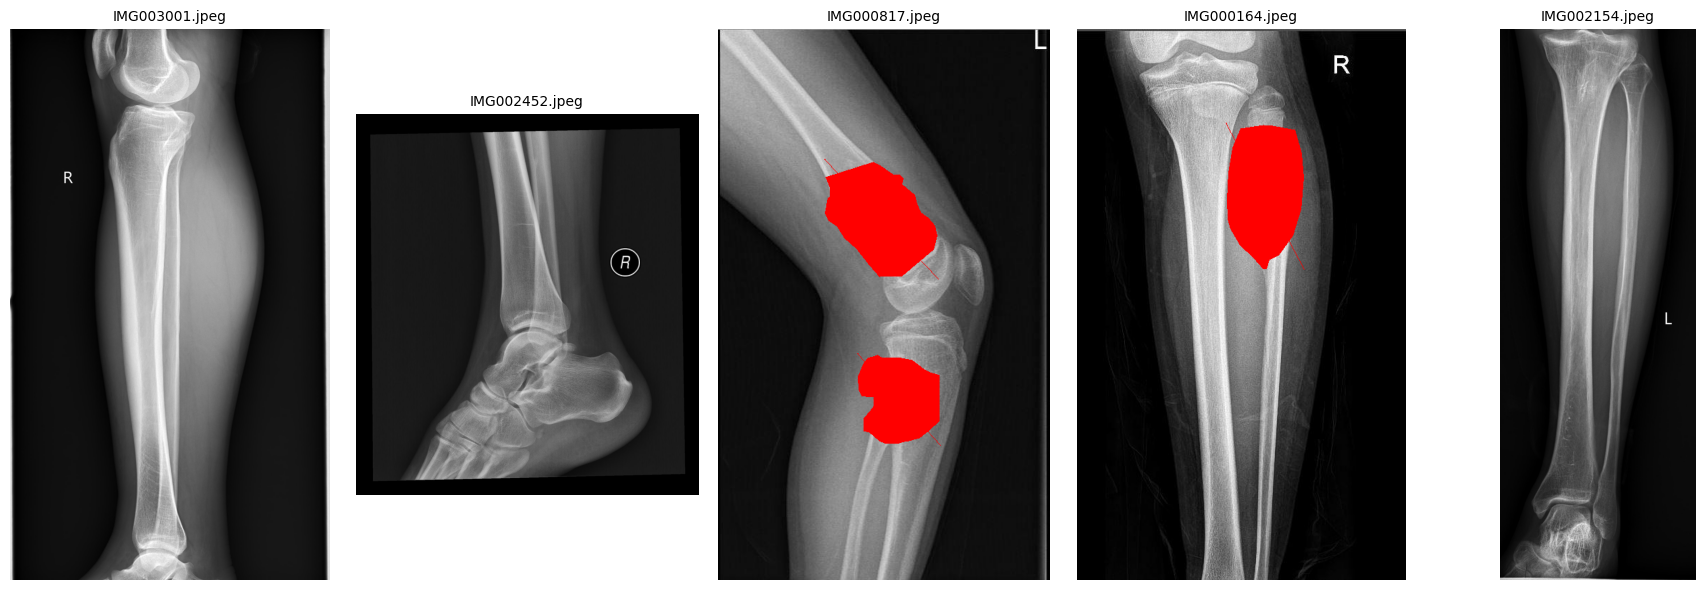

In [10]:
# hiển thị random 5 hình trước khi xử lý ảnh
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Tuple

# Cấu hình
image_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/images'
annotation_dir = '/kaggle/input/btxrd-data/BTXRD/BTXRD/Annotations'
num_images_to_show = 5
mask_color = [255, 0, 0]  # Red

def create_mask(img_size: Tuple[int, int], ann_path: str) -> np.ndarray:
    mask = Image.new('L', img_size, 0)
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if polygon_points:
                        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        except Exception as e:
            print(f"Lỗi annotation {ann_path}: {e}")
    return np.array(mask)

# Lấy danh sách tất cả ảnh trong thư mục
all_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Chọn ngẫu nhiên 5 ảnh
selected_filenames = random.sample(all_filenames, min(num_images_to_show, len(all_filenames)))

# Plot ảnh với mask
plt.figure(figsize=(18, 6))
for i, fname in enumerate(selected_filenames):
    img_path = os.path.join(image_dir, fname)
    ann_fname = os.path.splitext(fname)[0] + '.json'
    ann_path = os.path.join(annotation_dir, ann_fname)

    try:
        img_pil = Image.open(img_path).convert('L')
        img_np = np.array(img_pil)

        mask_np = create_mask(img_pil.size, ann_path)
        color_img = np.stack([img_np] * 3, axis=-1)
        color_img[mask_np == 1] = mask_color

        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(color_img)
        plt.title(fname, fontsize=10)
        plt.axis('off')
    except Exception as e:
        print(f"Lỗi khi xử lý {fname}: {e}")
        continue

plt.tight_layout()
plt.show()


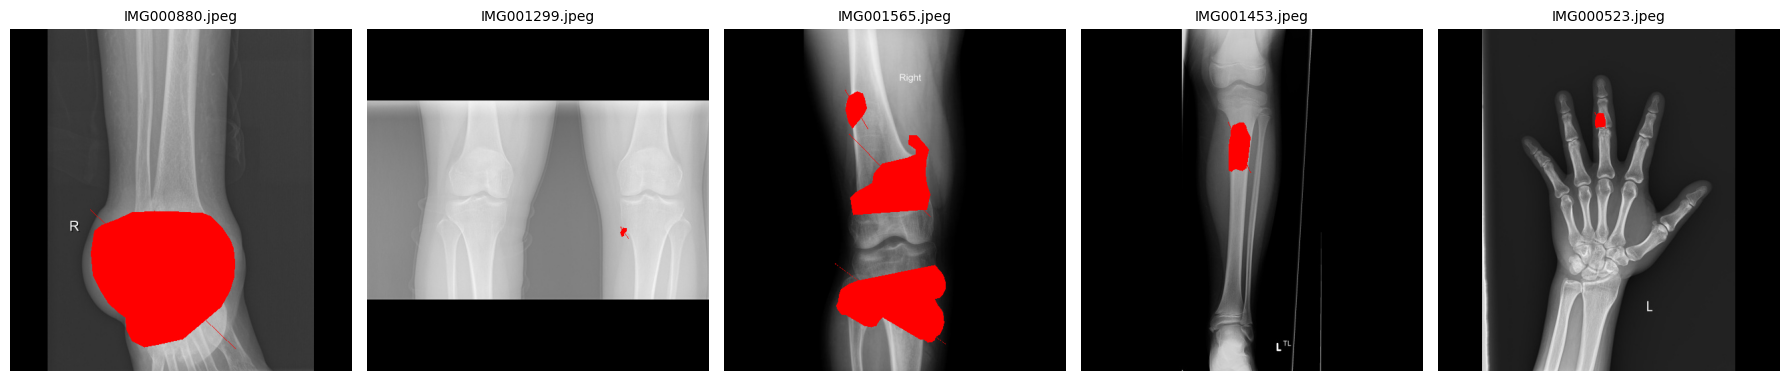

In [18]:
# hiển thị random 5 hình sau khi xử lý ảnh
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from typing import Tuple

# Cấu hình
image_dir = '/kaggle/input/btxrd-data/btxrd-v2.1/train/images'
annotation_dir = '/kaggle/input/btxrd-data/btxrd-v2.1/train/annotations'
num_images_to_show = 5
mask_color = [255, 0, 0]  # Red

def create_mask(img_size: Tuple[int, int], ann_path: str) -> np.ndarray:
    mask = Image.new('L', img_size, 0)
    if os.path.exists(ann_path):
        try:
            with open(ann_path, 'r') as f:
                data = json.load(f)
                for shape in data.get('shapes', []):
                    points = shape.get('points', [])
                    polygon_points = [(int(x), int(y)) for x, y in points]
                    if polygon_points:
                        ImageDraw.Draw(mask).polygon(polygon_points, outline=1, fill=1)
        except Exception as e:
            print(f"Lỗi annotation {ann_path}: {e}")
    return np.array(mask)

# Lấy danh sách tất cả ảnh trong thư mục
all_filenames = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Chọn ngẫu nhiên 5 ảnh
selected_filenames = random.sample(all_filenames, min(num_images_to_show, len(all_filenames)))

# Plot ảnh với mask
plt.figure(figsize=(18, 6))
for i, fname in enumerate(selected_filenames):
    img_path = os.path.join(image_dir, fname)
    ann_fname = os.path.splitext(fname)[0] + '.json'
    ann_path = os.path.join(annotation_dir, ann_fname)

    try:
        img_pil = Image.open(img_path).convert('L')
        img_np = np.array(img_pil)

        mask_np = create_mask(img_pil.size, ann_path)
        color_img = np.stack([img_np] * 3, axis=-1)
        color_img[mask_np == 1] = mask_color

        plt.subplot(1, num_images_to_show, i + 1)
        plt.imshow(color_img)
        plt.title(fname, fontsize=10)
        plt.axis('off')
    except Exception as e:
        print(f"Lỗi khi xử lý {fname}: {e}")
        continue

plt.tight_layout()
plt.show()


ghi lại ảnh thuộc tập nào vào excel

In [12]:
# import pandas as pd
# import os
# import glob
# from tqdm import tqdm # Để xem tiến trình nếu nhiều file

# # --- 1. Định nghĩa Đường dẫn ---

# # File Excel gốc chứa thông tin ban đầu
# excel_input_path = "/kaggle/input/btxrd-data/classification.xlsx"

# # Đường dẫn gốc đến thư mục chứa dữ liệu đã xử lý và chia tập
# processed_base_dir = "/kaggle/working/btxrd-v2.1"

# # File Excel mới sẽ được tạo ra với cột 'phan_loai'
# excel_output_path = "/kaggle/working/classification_with_phan_loai.xlsx"

# # Tên cột mới
# new_column_name = 'phan_loai'

# print("--- Cấu hình ---")
# print(f"File Excel gốc: {excel_input_path}")
# print(f"Thư mục dữ liệu đã xử lý để quét: {processed_base_dir}")
# print(f"File Excel kết quả sẽ lưu tại: {excel_output_path}")
# print(f"Tên cột mới sẽ thêm: '{new_column_name}'")
# print("-" * 30)

# # --- 2. Kiểm tra sự tồn tại ---
# if not os.path.exists(excel_input_path):
#     print(f"LỖI: File Excel gốc '{excel_input_path}' không tồn tại!")
#     exit()
# if not os.path.isdir(processed_base_dir):
#     print(f"LỖI: Thư mục dữ liệu đã xử lý '{processed_base_dir}' không tồn tại!")
#     print("Hãy đảm bảo bạn đã chạy các bước tạo thư mục này trước đó.")
#     exit()

# # --- 3. Đọc File Excel gốc ---
# print(f"--- Bước 3: Đọc file Excel '{os.path.basename(excel_input_path)}' ---")
# try:
#     # Đọc và đảm bảo cột image_filename là string
#     df = pd.read_excel(excel_input_path, dtype={'image_filename': str})
#     if 'image_filename' not in df.columns:
#         raise ValueError("File Excel phải chứa cột 'image_filename'.")
#     df['image_filename'] = df['image_filename'].str.strip() # Loại bỏ khoảng trắng thừa
#     print(f"Đã đọc thành công {len(df)} dòng ban đầu.")
#     # Loại bỏ các dòng có image_filename rỗng/NaN
#     initial_rows = len(df)
#     df.dropna(subset=['image_filename'], inplace=True)
#     df = df[df['image_filename'] != ''] # Bỏ cả chuỗi rỗng
#     if len(df) < initial_rows:
#         print(f"Cảnh báo: Đã loại bỏ {initial_rows - len(df)} dòng do thiếu 'image_filename'.")
#     if df.empty:
#         print("Lỗi: Không còn dòng nào hợp lệ với 'image_filename' trong DataFrame.")
#         exit()
#     print(f"Số dòng hợp lệ có 'image_filename': {len(df)}")
# except ValueError as ve:
#     print(f"Lỗi dữ liệu trong file Excel: {ve}")
#     exit()
# except Exception as e:
#     print(f"Lỗi không xác định khi đọc file Excel: {e}")
#     exit()
# print("-" * 30)

# # --- 4. Quét thư mục đã xử lý để tạo bản đồ ánh xạ ---
# print(f"--- Bước 4: Quét thư mục '{processed_base_dir}' để xác định loại tập ---")
# filename_to_set_map = {}
# processed_files_count = 0
# possible_splits = ['train', 'val', 'test']
# found_files_details = {split: set() for split in possible_splits}

# for split in possible_splits:
#     image_dir_path = os.path.join(processed_base_dir, split, 'images')
#     print(f"  Đang quét: '{image_dir_path}'")
#     if not os.path.isdir(image_dir_path):
#         print(f"    Cảnh báo: Thư mục không tồn tại, bỏ qua tập '{split}'.")
#         continue

#     # Tìm tất cả các file trong thư mục images của split này
#     # Sử dụng tqdm nếu có nhiều file
#     files_in_split = glob.glob(os.path.join(image_dir_path, '*.*'))
#     split_file_count = 0
#     for filepath in files_in_split:
#         filename = os.path.basename(filepath)
#         # Kiểm tra xem file này đã được gán vào tập khác chưa
#         if filename in filename_to_set_map:
#             print(f"    Cảnh báo: File '{filename}' được tìm thấy ở cả tập '{filename_to_set_map[filename]}' và '{split}'. Sẽ giữ lại loại '{split}'.")
#         filename_to_set_map[filename] = split
#         found_files_details[split].add(filename)
#         split_file_count += 1

#     print(f"    Tìm thấy {split_file_count} file trong tập '{split}'.")
#     processed_files_count += split_file_count

# # Kiểm tra chồng chéo nghiêm trọng
# overlap_tv = found_files_details['train'].intersection(found_files_details['val'])
# overlap_tt = found_files_details['train'].intersection(found_files_details['test'])
# overlap_vt = found_files_details['val'].intersection(found_files_details['test'])
# if overlap_tv: print(f"Cảnh báo NGHIÊM TRỌNG: {len(overlap_tv)} file tồn tại trong cả train và val!")
# if overlap_tt: print(f"Cảnh báo NGHIÊM TRỌNG: {len(overlap_tt)} file tồn tại trong cả train và test!")
# if overlap_vt: print(f"Cảnh báo NGHIÊM TRỌNG: {len(overlap_vt)} file tồn tại trong cả val và test!")


# print(f"Đã tạo bản đồ ánh xạ cho {len(filename_to_set_map)} tên file duy nhất từ các thư mục đã xử lý.")
# print("-" * 30)

# # --- 5. Thêm cột mới vào DataFrame ---
# print(f"--- Bước 5: Thêm cột '{new_column_name}' vào DataFrame ---")

# # Sử dụng .map() để tạo cột mới dựa trên dictionary đã tạo
# # Những 'image_filename' nào trong Excel không có trong bản đồ sẽ nhận giá trị NaN
# df[new_column_name] = df['image_filename'].map(filename_to_set_map)

# # Kiểm tra kết quả
# assigned_counts = df[new_column_name].value_counts(dropna=False) # dropna=False để đếm cả NaN
# print("Số lượng ảnh được gán cho mỗi loại (bao gồm cả không tìm thấy - NaN):")
# print(assigned_counts.to_string()) # In đầy đủ

# num_nan = df[new_column_name].isna().sum()
# if num_nan > 0:
#     print(f"\nCảnh báo: {num_nan} ảnh trong file Excel không được tìm thấy trong bất kỳ thư mục images nào của '{processed_base_dir}'.")
#     print("  Lý do có thể là:")
#     print("  - Tên file trong Excel (cột 'image_filename') không khớp chính xác với tên file đã xử lý.")
#     print("  - Những ảnh này đã bị bỏ qua trong các bước xử lý trước đó.")
#     # In ví dụ nếu cần debug
#     # print("  Ví dụ các image_filename không được gán loại:")
#     # print(df[df[new_column_name].isna()]['image_filename'].head())

# print("-" * 30)

# # --- 6. Lưu DataFrame kết quả vào file Excel MỚI ---
# print(f"--- Bước 6: Lưu DataFrame vào file Excel mới: {excel_output_path} ---")
# try:
#     df.to_excel(excel_output_path, index=False)
#     print(f"Đã lưu thành công DataFrame với cột '{new_column_name}' vào: {excel_output_path}")
#     print("File này nằm trong thư mục /kaggle/working/.")
# except Exception as e:
#     print(f"Lỗi khi lưu file Excel mới: {e}")
# print("-" * 30)

# print("--- Hoàn thành ---")

chưa

In [13]:
# import cv2 # Vẫn có thể cần nếu bạn dùng nó ở đâu đó khác
# import numpy as np
# import pandas as pd
# import os
# import json
# import PIL.Image
# from PIL import Image, ImageDraw # Import cụ thể hơn
# import random
# import matplotlib.pyplot as plt
# from typing import Tuple, List, Optional, Dict, Any

# # --- 1. Cấu hình ---

# # Đường dẫn (Giả sử các biến này đã được định nghĩa đúng ở nơi khác)
# # classification_file_path = "/path/to/your/classification.xlsx"
# # image_v2 = "/path/to/your/processed/images" # Thư mục chứa ảnh đã xử lý (train/val/test)
# # annotation_v2 = "/path/to/your/processed/annotations" # Thư mục chứa JSON đã xử lý

# # Cấu hình hiển thị và xoay
# rotation_angle: float = 90.0
# num_visualizations: int = 5 # Giảm số lượng nếu cần nhẹ hơn nữa
# mask_color: List[int] = [255, 0, 0] # Màu đỏ cho mask
# rotation_fill_color: int = 0 # Màu nền khi xoay (đen)

# # *** KÍCH THƯỚC MỚI ĐỂ HIỂN THỊ (NHỎ HƠN) ***
# # Chọn kích thước phù hợp, ví dụ 256x256 hoặc 128x128
# vis_size: Tuple[int, int] = (256, 256)
# #--------------------------------------------

# print("--- Cấu hình Visualization ---")
# print(f"Góc xoay: {rotation_angle}")
# print(f"Số lượng ảnh hiển thị: {num_visualizations}")
# print(f"Kích thước hiển thị: {vis_size}")
# print("-" * 30)


# # --- 2. Hàm trợ giúp (Tối ưu hóa) ---

# # Hàm tạo mask từ JSON, nhưng tạo ở kích thước hiển thị và scale points
# def create_mask_pil_scaled(
#     orig_img_size: Tuple[int, int], # Kích thước ảnh gốc
#     target_vis_size: Tuple[int, int], # Kích thước mask cần tạo (kích thước hiển thị)
#     ann_path: str,
#     target_label: Optional[str] = None # Thêm tùy chọn chỉ vẽ label cụ thể
#     ) -> Image.Image:
#     """Tạo mask PIL ở kích thước hiển thị, scale points từ JSON."""
#     mask = Image.new('L', target_vis_size, 0) # Tạo mask nhỏ
#     if not os.path.exists(ann_path):
#         return mask # Trả về mask trống nếu không có file

#     orig_w, orig_h = orig_img_size
#     vis_w, vis_h = target_vis_size

#     # Tính tỉ lệ scale
#     scale_x = vis_w / orig_w if orig_w > 0 else 1
#     scale_y = vis_h / orig_h if orig_h > 0 else 1

#     try:
#         with open(ann_path, 'r', encoding='utf-8') as f:
#             data = json.load(f)
#             draw = ImageDraw.Draw(mask)
#             for shape in data.get('shapes', []):
#                 label = shape.get('label', '')
#                 # Nếu có target_label, chỉ vẽ label đó
#                 if target_label and label.lower() != target_label.lower():
#                     continue

#                 points = shape.get('points', [])
#                 shape_type = shape.get('shape_type', 'polygon')

#                 if isinstance(points, list) and len(points) >= 2:
#                     # *** Scale points về kích thước hiển thị ***
#                     scaled_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
#                     #-----------------------------------------

#                     # Vẽ polygon hoặc rectangle đã scale
#                     if shape_type == 'rectangle' and len(scaled_points) == 2:
#                         # Chuyển rect thành 4 điểm để fill
#                         p1, p2 = scaled_points
#                         draw.polygon([(p1[0], p1[1]), (p2[0], p1[1]), (p2[0], p2[1]), (p1[0], p2[1])], outline=1, fill=1)
#                     elif len(scaled_points) > 2: # Vẽ polygon
#                         draw.polygon(scaled_points, outline=1, fill=1)

#     except json.JSONDecodeError:
#         print(f"Lỗi JSON file: {ann_path}")
#     except Exception as e:
#         print(f"Lỗi khi tạo mask từ {os.path.basename(ann_path)}: {e}")
#     return mask

# # Hàm áp dụng mask màu (giữ nguyên nhưng input sẽ nhỏ hơn)
# def apply_mask(image_np: np.ndarray, mask_np: np.ndarray, color: List[int]) -> np.ndarray:
#     # Chuyển ảnh xám thành ảnh màu nếu cần
#     if image_np.ndim == 2:
#         color_img = np.stack([image_np] * 3, axis=-1)
#     elif image_np.ndim == 3 and image_np.shape[2] == 1:
#         color_img = np.concatenate([image_np] * 3, axis=-1)
#     elif image_np.ndim == 3 and image_np.shape[2] == 3:
#         color_img = image_np.copy() # Nếu ảnh đã là màu thì copy
#     else:
#         # Bỏ qua ảnh không hỗ trợ thay vì raise lỗi
#         print(f"Định dạng ảnh không hỗ trợ để áp mask: {image_np.shape}")
#         # Trả về ảnh gốc hoặc ảnh rỗng tùy logic mong muốn
#         return np.stack([image_np]*3, axis=-1) if image_np.ndim == 2 else image_np # Thử trả về

#     # Áp mask
#     mask_bool = mask_np.astype(bool)
#     try:
#         color_img[mask_bool] = color
#     except IndexError:
#          print(f"Lỗi IndexError khi áp mask. Shape ảnh: {color_img.shape}, Shape mask: {mask_bool.shape}")
#          # Có thể do resize/rotate làm lệch kích thước nhẹ
#     return color_img

# # Hàm lấy đường dẫn hợp lệ (giữ nguyên)
# def get_valid_paths(base_dir_img: str, base_dir_ann: str, full_fname_from_excel: str) -> Optional[Tuple[str, str]]:
#     img_path = os.path.join(base_dir_img, full_fname_from_excel)
#     if not os.path.exists(img_path): return None
#     json_filename = os.path.splitext(full_fname_from_excel)[0] + '.json'
#     json_path = os.path.join(base_dir_ann, json_filename)
#     if not os.path.exists(json_path): return None
#     return img_path, json_path

# # Hàm vẽ (giữ nguyên)
# def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str):
#     ax.imshow(image_data, cmap='gray' if image_data.ndim == 2 else None) # Thêm cmap='gray' nếu ảnh là 1 kênh
#     ax.set_title(title, fontsize=8) # Giảm fontsize
#     ax.axis('off')

# # --- 3. Lấy danh sách file hợp lệ từ Excel ---
# print("\n--- Bước 3: Đọc Excel và tìm file hợp lệ ---")
# valid_files_details: Dict[str, Dict[str, str]] = {}
# try:
#     # Giả sử classification_file_path, image_v2, annotation_v2 đã được định nghĩa ở code khác
#     # Nếu không, bạn cần thêm định nghĩa chúng ở đây
#     # Ví dụ:
#     # classification_file_path = "/kaggle/input/btxrd-data/classification.xlsx"
#     # image_v2 = "/kaggle/working/btxrd-processed-512-gray-excel-names/train/images" # Ví dụ đường dẫn đến ảnh train
#     # annotation_v2 = "/kaggle/working/btxrd-processed-512-gray-excel-names/train/annotations" # Ví dụ đường dẫn annotations train
#     # ==> Lưu ý: Code này sẽ hiệu quả hơn nếu quét tất cả các tập train/val/test một lần

#     df = pd.read_excel(classification_file_path, dtype={'image_filename': str}) # Đọc cột filename là string
#     if 'image_filename' not in df.columns:
#         print(f"LỖI: Không tìm thấy cột 'image_filename' trong file Excel.")
#         exit()

#     print(f"Đọc {len(df)} dòng từ Excel. Tìm kiếm trong:")
#     # Giả sử bạn muốn quét cả 3 tập, nếu không hãy chỉ định đúng image_v2, annotation_v2
#     base_dirs = {
#         'train': (os.path.join(processed_base_dir, 'train', 'images'), os.path.join(processed_base_dir, 'train', 'annotations')),
#         'val':   (os.path.join(processed_base_dir, 'val', 'images'), os.path.join(processed_base_dir, 'val', 'annotations')),
#         'test':  (os.path.join(processed_base_dir, 'test', 'images'), os.path.join(processed_base_dir, 'test', 'annotations'))
#     }
#     print(f" - Ảnh nguồn train: {base_dirs['train'][0]}")
#     print(f" - Anno nguồn train: {base_dirs['train'][1]}")
#     # (Tương tự cho val, test nếu cần)


#     processed_count = 0
#     skipped_missing_file = 0
#     # Chỉ duyệt qua các tên file duy nhất trong excel
#     for full_filename in tqdm(df['image_filename'].dropna().unique(), desc="Kiểm tra file từ Excel"):
#         found_in_split = None
#         paths = None
#         # Kiểm tra trong từng split xem file tồn tại ở đâu
#         for split_name, (img_dir, ann_dir) in base_dirs.items():
#              # Nếu bạn đã có cột 'type' trong excel thì dùng nó thay vì quét
#              # excel_type = df.loc[df['image_filename'] == full_filename, 'type'].iloc[0]
#              # if excel_type == split_name: ...
#              paths = get_valid_paths(img_dir, ann_dir, full_filename)
#              if paths:
#                  found_in_split = split_name
#                  break # Tìm thấy thì dừng

#         if paths:
#             img_path, json_path = paths
#             # Lưu trữ đường dẫn hợp lệ, key là tên file đầy đủ
#             valid_files_details[full_filename] = {'img_path': img_path, 'json_path': json_path, 'split': found_in_split}
#             processed_count += 1
#         else:
#             skipped_missing_file +=1

#     if not valid_files_details:
#         print("\nLỖI: Không tìm thấy cặp file ảnh và annotation hợp lệ nào dựa trên Excel.")
#         print(f"Kiểm tra nội dung cột 'image_filename' và sự tồn tại của file trong các thư mục nguồn.")
#         exit()

#     print(f"\nTìm thấy {len(valid_files_details)} cặp ảnh/annotation hợp lệ.")
#     if skipped_missing_file > 0:
#         print(f"Đã bỏ qua {skipped_missing_file} tên file từ Excel do không tìm thấy file ảnh/annotation tương ứng.")

# except FileNotFoundError:
#     print(f"LỖI: Không tìm thấy file Excel tại: {classification_file_path}")
#     exit()
# except KeyError as e:
#      print(f"LỖI: Thiếu cột '{e}' trong file Excel.")
#      exit()
# except Exception as e:
#     print(f"LỖI khi đọc hoặc xử lý file Excel: {e}")
#     exit()
# print("-" * 30)


# # --- 4. Chọn ngẫu nhiên, xử lý và hiển thị tuần tự ---
# print(f"--- Bước 4: Chọn ngẫu nhiên {num_visualizations} ảnh và hiển thị ---")
# available_fnames = list(valid_files_details.keys())
# num_to_select = min(num_visualizations, len(available_fnames))

# if num_to_select == 0:
#     print("Không có ảnh nào để hiển thị.")
#     exit()

# selected_files = random.sample(available_fnames, num_to_select)
# print(f"Các file được chọn: {selected_files}")

# # Tạo figure một lần
# # Chia thành num_to_select hàng, 2 cột
# fig, axes = plt.subplots(num_to_select, 2, figsize=(8, 4 * num_to_select)) # Giảm kích thước figure
# # Xử lý trường hợp chỉ có 1 ảnh (axes không phải là mảng 2D)
# if num_to_select == 1:
#     axes = np.array([axes]) # Chuyển thành mảng để truy cập bằng chỉ số [0, 0], [0, 1]

# plot_row = 0
# for fname in selected_files:
#     details = valid_files_details[fname]
#     print(f"\nĐang xử lý: {fname} (từ tập {details.get('split','N/A')})")

#     try:
#         # 1. Đọc ảnh gốc và lấy kích thước gốc
#         img_orig_pil = Image.open(details['img_path']).convert('L')
#         orig_size = img_orig_pil.size # (width, height)

#         # 2. *** Resize ảnh gốc về kích thước hiển thị ***
#         img_vis_pil = img_orig_pil.resize(vis_size, Image.Resampling.LANCZOS) # Lanczos tốt cho thu nhỏ
#         img_vis_np = np.array(img_vis_pil)

#         # 3. *** Tạo mask ở kích thước hiển thị ***
#         # Cần truyền kích thước gốc để scale points
#         mask_vis_pil = create_mask_pil_scaled(orig_size, vis_size, details['json_path'], target_label="other mt") # Chỉ lấy label 'other mt'
#         mask_vis_np = np.array(mask_vis_pil)

#         # 4. Tạo ảnh gốc có overlay (ở kích thước hiển thị)
#         overlay_orig_np = apply_mask(img_vis_np, mask_vis_np, mask_color)

#         # 5. Xoay ảnh và mask (ở kích thước hiển thị)
#         # expand=False để giữ kích thước, expand=True sẽ làm ảnh lớn hơn
#         img_rotated_pil = img_vis_pil.rotate(rotation_angle, resample=Image.Resampling.NEAREST, expand=False, fillcolor=rotation_fill_color)
#         mask_rotated_pil = mask_vis_pil.rotate(rotation_angle, resample=Image.Resampling.NEAREST, expand=False, fillcolor=0) # Dùng NEAREST cho mask

#         # 6. Tạo ảnh xoay có overlay
#         overlay_rotated_np = apply_mask(np.array(img_rotated_pil), np.array(mask_rotated_pil), mask_color)

#         # 7. Vẽ lên subplot tương ứng
#         plot_image(axes[plot_row, 0], overlay_orig_np, f"Original (Vis Size): {fname[:20]}...") # Rút ngắn tên file
#         plot_image(axes[plot_row, 1], overlay_rotated_np, f"Rotated {rotation_angle}° (Vis Size)")

#         plot_row += 1 # Chuyển sang hàng subplot tiếp theo

#     except FileNotFoundError:
#         print(f"  LỖI: Không tìm thấy file khi xử lý: {fname}")
#         # Đảm bảo plot_row tăng đúng cách nếu có lỗi
#         if plot_row < num_to_select:
#              axes[plot_row, 0].set_title(f"Lỗi tải: {fname[:20]}...", fontsize=8); axes[plot_row, 0].axis('off')
#              axes[plot_row, 1].set_title("Lỗi", fontsize=8); axes[plot_row, 1].axis('off')
#              plot_row +=1
#     except Exception as e:
#         print(f"  LỖI không xác định khi xử lý {fname}: {e}")
#         if plot_row < num_to_select:
#              axes[plot_row, 0].set_title(f"Lỗi xử lý: {fname[:20]}...", fontsize=8); axes[plot_row, 0].axis('off')
#              axes[plot_row, 1].set_title("Lỗi", fontsize=8); axes[plot_row, 1].axis('off')
#              plot_row +=1

# # Hiển thị tất cả các subplot
# plt.tight_layout(pad=1.5) # Giảm padding
# plt.show()

# **SegNet**

Kiểm tra file: 100%|██████████| 3746/3746 [00:10<00:00, 350.83it/s] 



Phân chia dữ liệu: Train(1344), Val(336), Test(187)
Đang tính toán Mean/Std...


Tính Mean/Std: 100%|██████████| 250/250 [00:00<00:00, 282.99it/s]


Mean: 0.1953, Std Dev: 0.2392

Xây dựng và biên dịch Model U-Net...


Model: "UNet_filters64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 512, 512, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 512, 512, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 512, 512, 64)   │              0 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 512, 512, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 256, 256, 64)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 256, 256, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 256, 256, 128)  │              0 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 256, 256, 128)  │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,054,210 (118.46 MB)

 Trainable params: 31,042,434 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

Sử dụng Loss: combined_dice0.6_focal
Callbacks theo dõi: val_dice_coef_metric_tumor (mode=max)

Tính toán Class Weights...


Đếm pixels: 100%|██████████| 1344/1344 [00:02<00:00, 513.08it/s]


Class weights đã tính: Lớp 0: 0.5089, Lớp 1: 28.6592

Bắt đầu huấn luyện Model...
Epoch 1/120
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - acc: 0.8383 - dice_coef_metric_tumor: 0.0503 - loss: 0.7048 - mean_iou_all: 0.2505 - precision_tumor: 0.0486 - recall_tumor: 0.4353 - tumor_iou: 0.0727
Epoch 1: val_dice_coef_metric_tumor improved from -inf to 0.07802, saving model to best_unet_model_iou_focused_combined_dice0.6_focal_attnFalse.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 189s 480ms/step - acc: 0.8383 - dice_coef_metric_tumor: 0.0503 - loss: 0.7047 - mean_iou_all: 0.2505 - precision_tumor: 0.0486 - recall_tumor: 0.4356 - tumor_iou: 0.0729 - val_acc: 0.8461 - val_dice_coef_metric_tumor: 0.0780 - val_loss: 0.6563 - val_mean_iou_all: 0.2500 - val_precision_tumor: 0.0614 - val_recall_tumor: 0.5883 - val_tumor_iou: 0.0589 - learning_rate: 3.0000e-05
Epoch 2/120
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - acc: 0.8539 - dice_coef_metric_tumor: 0.0944 - loss: 0.6472 - mean_iou_all: 0.2515 - precisio

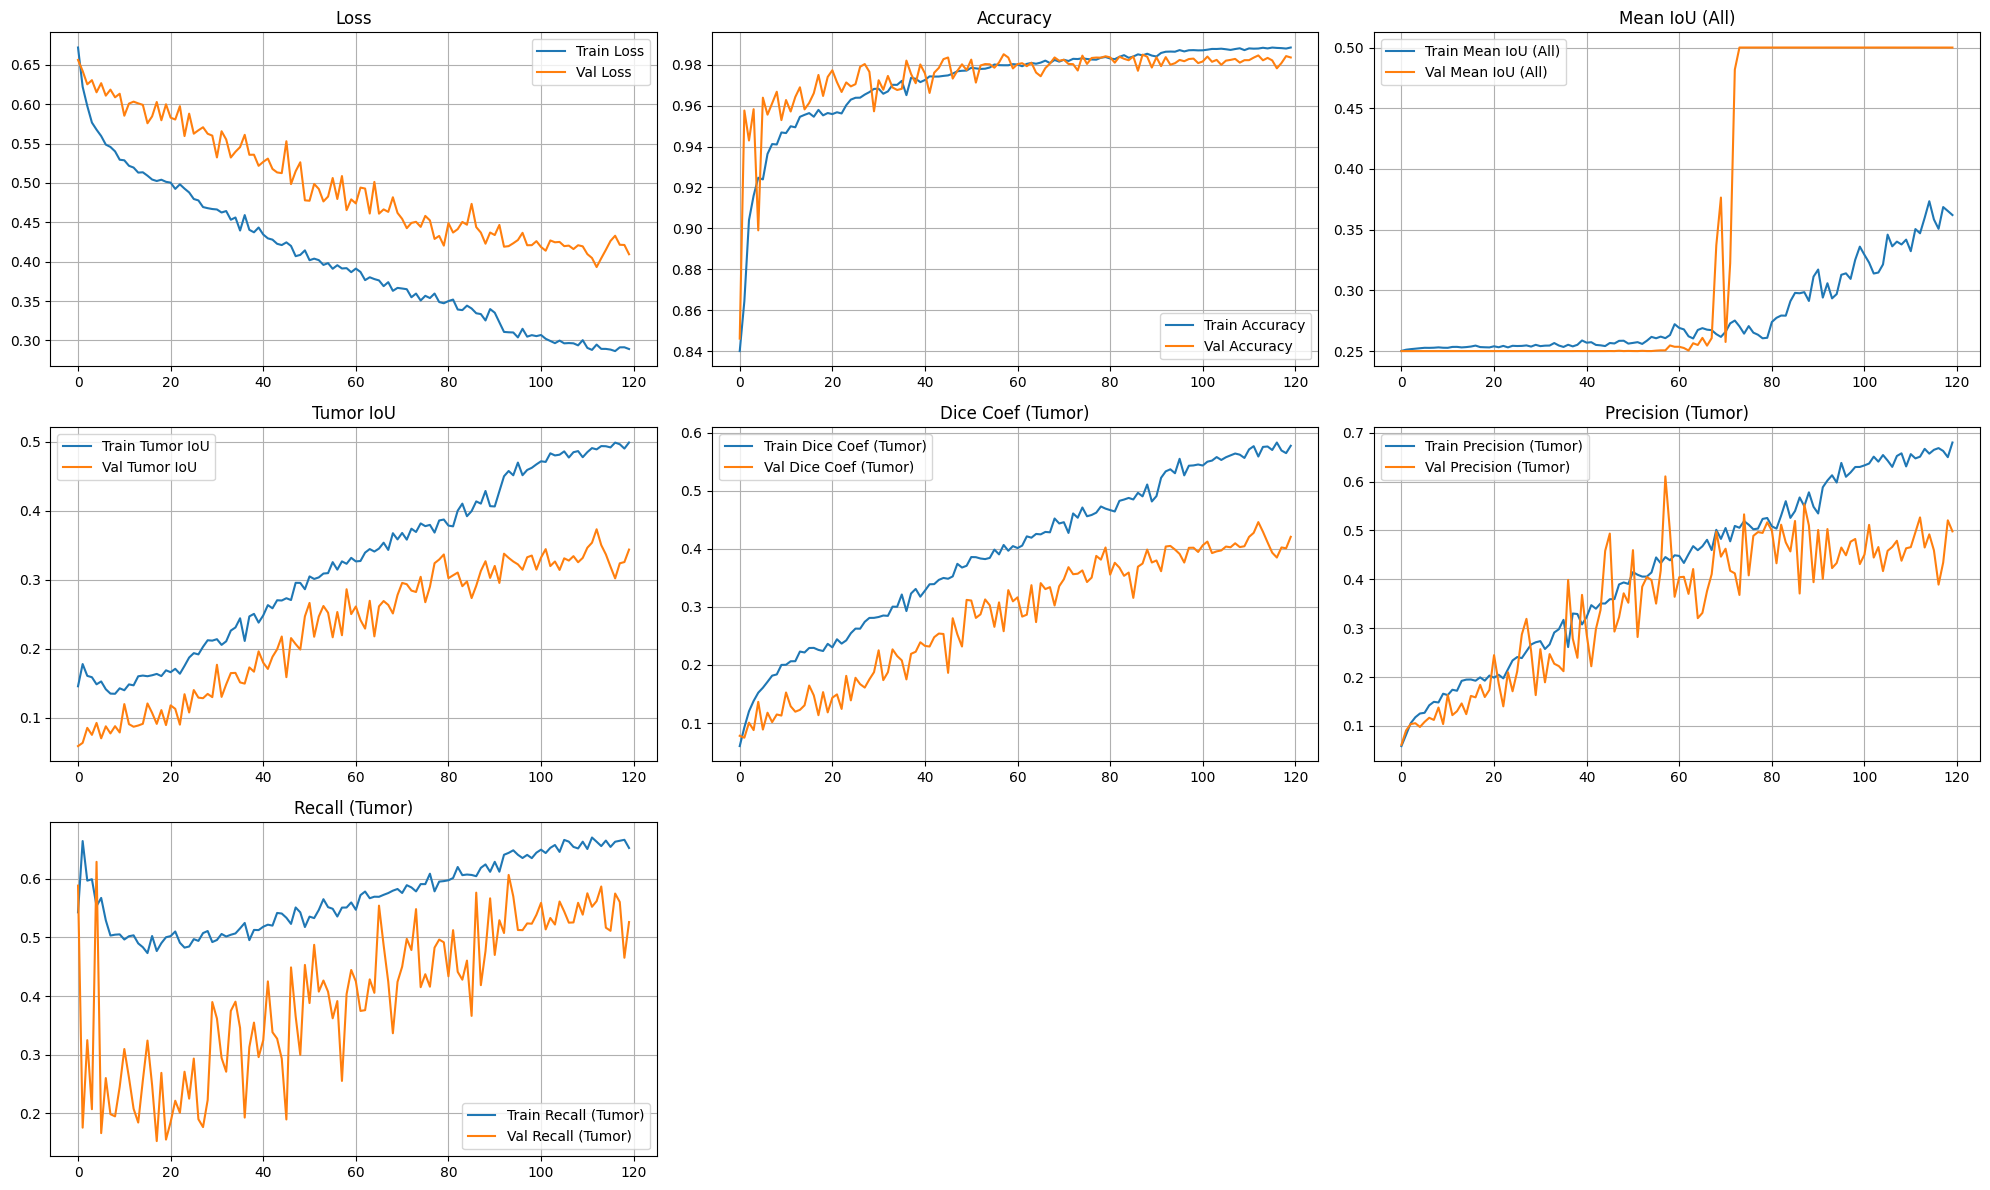


Đánh giá model trên tập kiểm thử...
Tải model tốt nhất từ: best_unet_model_iou_focused_combined_dice0.6_focal_attnFalse.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - acc: 0.9853 - dice_coef_metric_tumor: 0.5050 - loss: 0.3571 - mean_iou_all: 0.5473 - precision_tumor: 0.5234 - recall_tumor: 0.6395 - tumor_iou: 0.3998

--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---
 - Test loss: 0.3540
 - Test compile_metrics: 0.9866
--------------------------------------

Trực quan hóa dự đoán...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


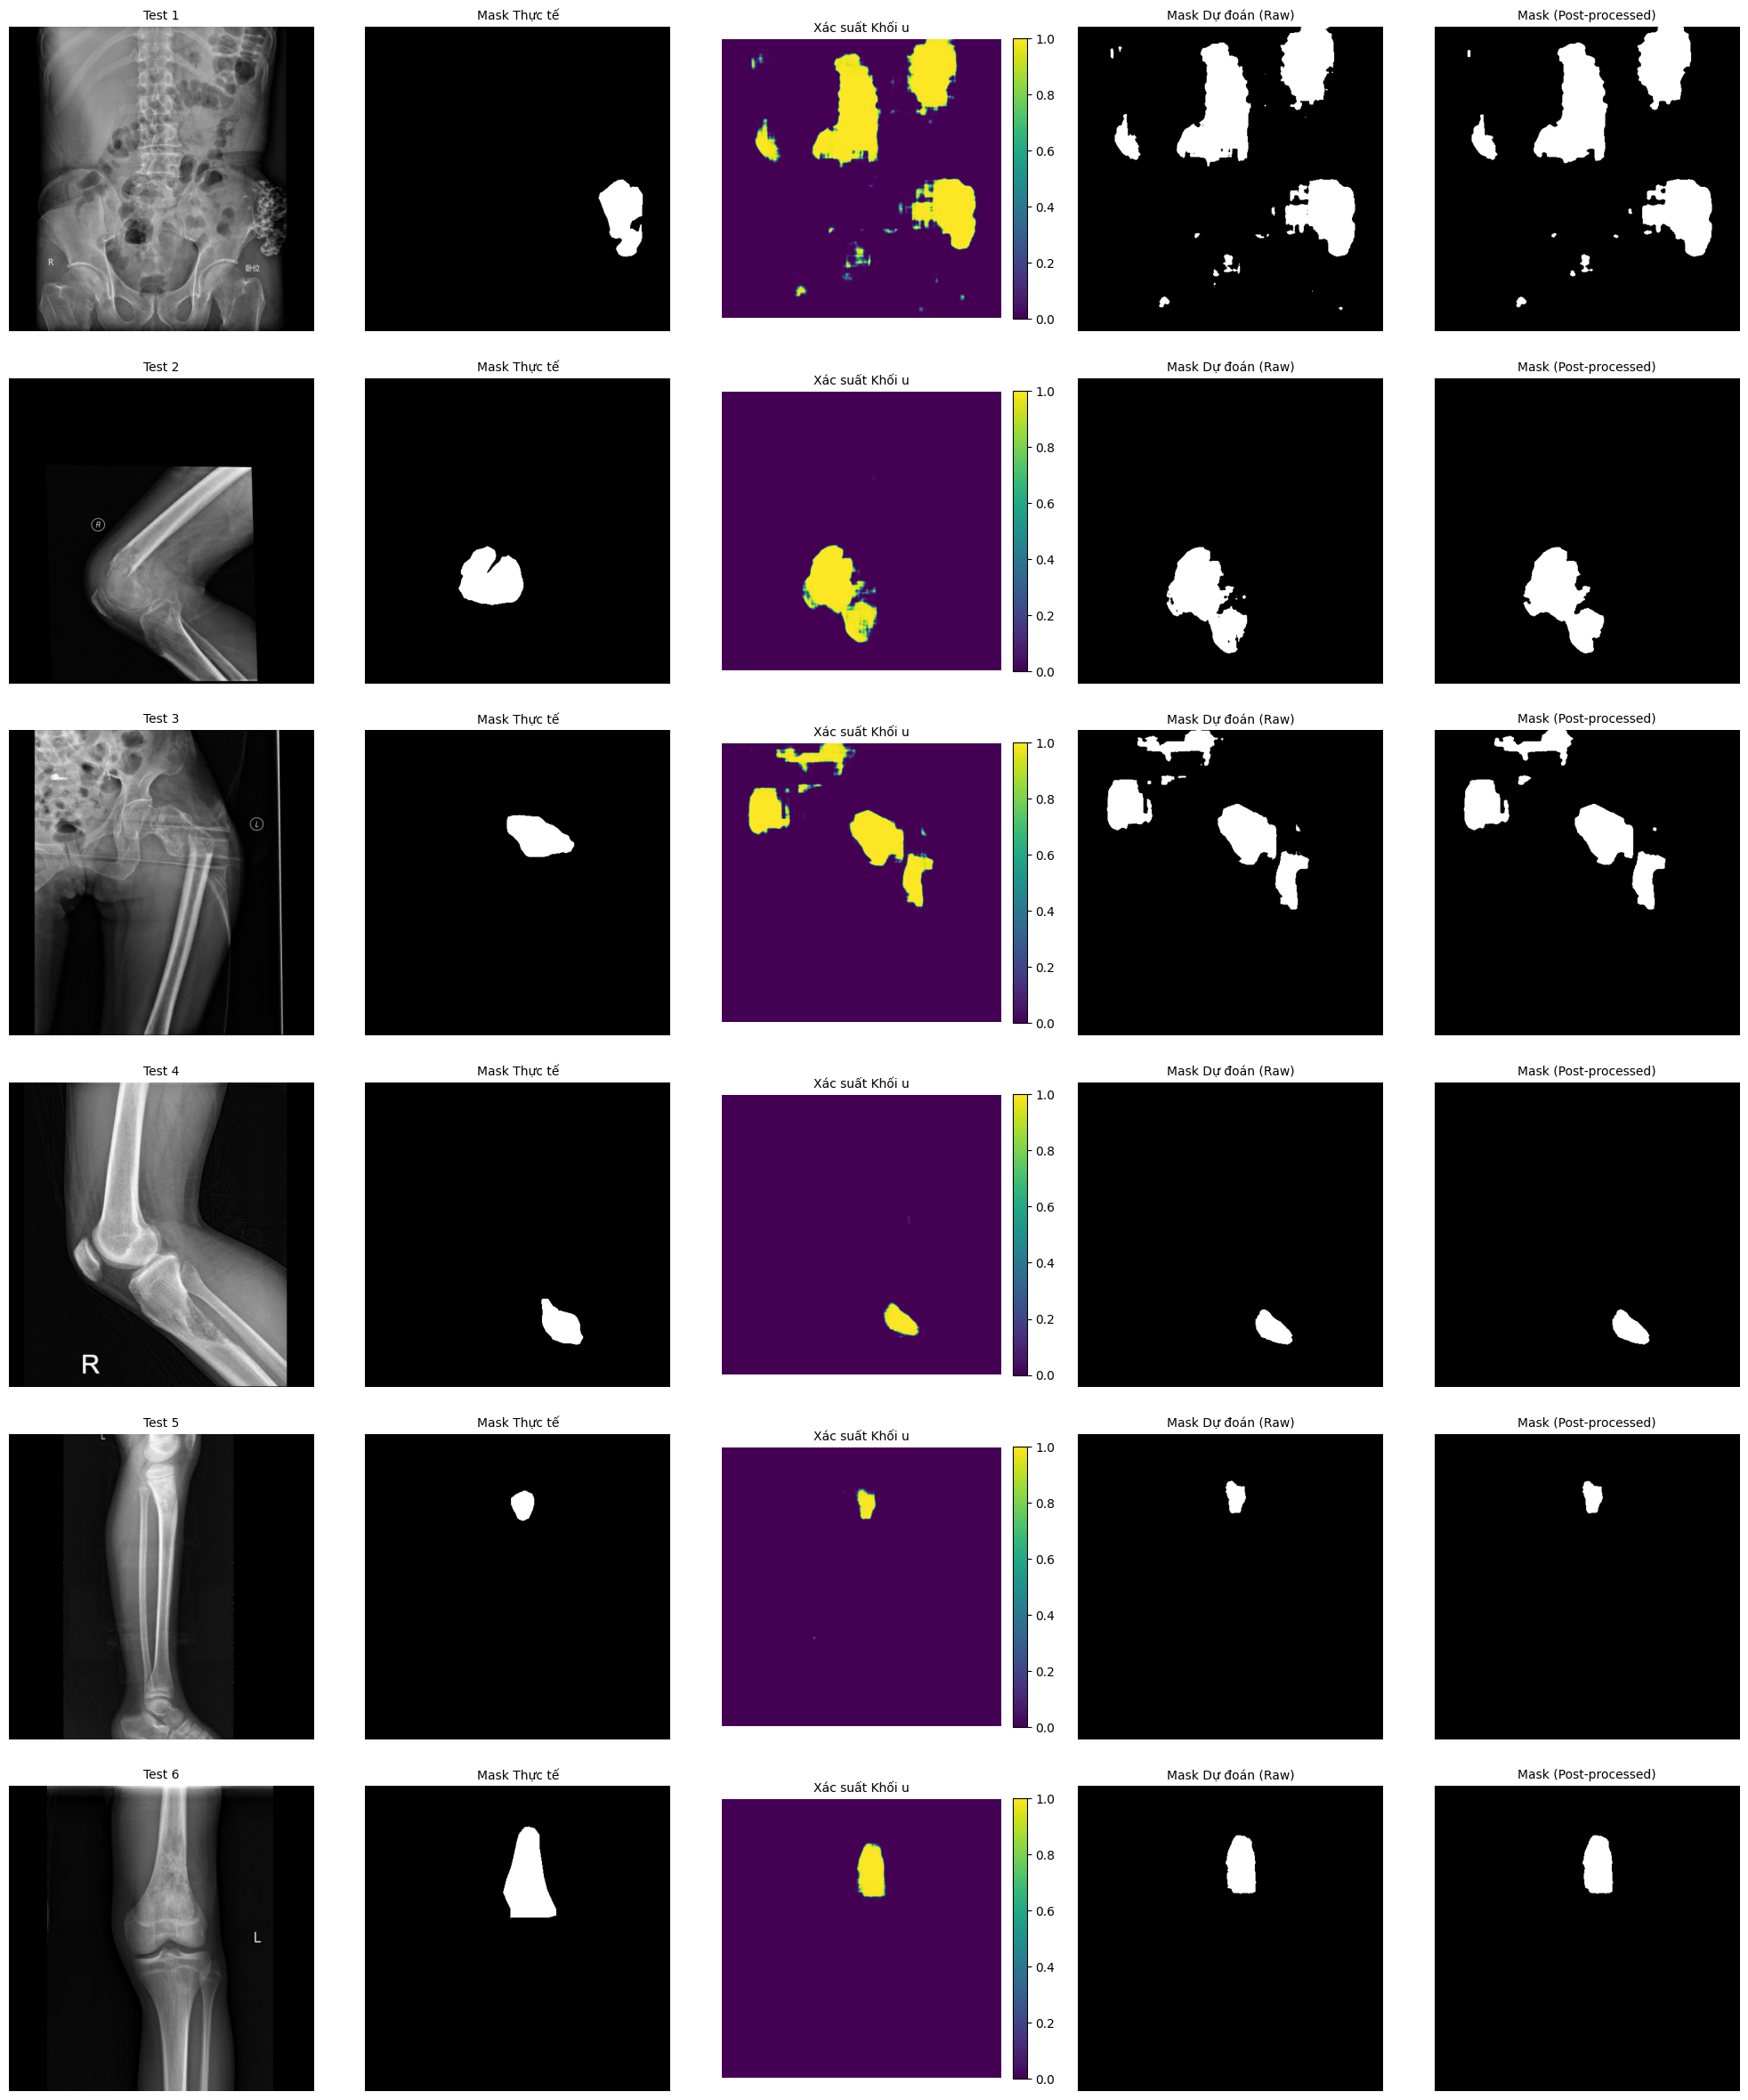


Script hoàn thành.


In [2]:
# đang chạy này
# -*- coding: utf-8 -*-
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw
from typing import List, Tuple, Optional
import cv2 # For post-processing

# --- Cấu hình ---
INPUT_DATA_ROOT = '/kaggle/input/btxrd-data' # THAY ĐỔI NẾU MÔI TRƯỜNG CỦA BẠN KHÁC
BASE_DATA_DIR = os.path.join(INPUT_DATA_ROOT, 'btxrd-v2.1')
CLASSIFICATION_FILE = os.path.join(INPUT_DATA_ROOT, 'classification.xlsx')
IMAGE_SUBDIR_NAME = 'images'
ANNOTATION_SUBDIR_NAME = 'annotations'

# Tham số Model & Huấn luyện
TARGET_SIZE = 512
N_CLASSES = 2 # 2 lớp: 0 (nền), 1 (khối u)
BATCH_SIZE = 4
BUFFER_SIZE = 100
EPOCHS = 120 # Tăng epochs, EarlyStopping sẽ xử lý
LEARNING_RATE = 3e-5 # Giữ LR nhỏ hoặc thử 5e-5
L2_REG_FACTOR = 1e-5
DROPOUT_RATE = 0.3

# --- Cải tiến để tăng IoU ---
USE_COMBINED_LOSS = True
DICE_LOSS_WEIGHT = 0.6 # Ưu tiên Dice hơn một chút, hoặc giữ 0.5
USE_FOCAL_LOSS_IN_COMBINED = True # **MẶC ĐỊNH SỬ DỤNG FOCAL LOSS**
FOCAL_LOSS_ALPHA = 0.25 # Alpha cho Focal Loss
FOCAL_LOSS_GAMMA = 2.0  # Gamma cho Focal Loss

USE_ATTENTION_UNET = False # Thử nghiệm bật/tắt sau
# USE_ALBUMENTATIONS = False # Tạm thời không dùng để giữ code đơn giản

APPLY_POST_PROCESSING = True
POST_PROCESSING_KERNEL_SIZE = (5,5)
MIN_AREA_POST_PROCESSING = 30

MODEL_CHECKPOINT_BASENAME = "best_unet_model_iou_focused"
TENSORBOARD_LOG_DIR = "./logs_unet_iou_focused"

# --- Các hằng số cho callback ---
PATIENCE_EARLY_STOPPING = 35 # Tăng patience
PATIENCE_REDUCE_LR = 12  # Tăng patience

# --- Hàm trợ giúp (Giữ nguyên) ---
def get_valid_paths(base_dir: str, split_type: str, img_filename_with_ext: str) -> Optional[Tuple[str, str]]:
    split_dir = os.path.join(base_dir, split_type); image_dir_path = os.path.join(split_dir, IMAGE_SUBDIR_NAME); annotation_dir_path = os.path.join(split_dir, ANNOTATION_SUBDIR_NAME)
    img_path = os.path.join(image_dir_path, img_filename_with_ext); base_name = os.path.splitext(img_filename_with_ext)[0]; json_filename = base_name + '.json'
    json_path = os.path.join(annotation_dir_path, json_filename)
    if os.path.exists(img_path) and os.path.exists(json_path): return img_path, json_path
    return None

def create_mask_pil(mask_size: Tuple[int, int], json_path: str) -> Image.Image:
    if not os.path.exists(json_path): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    mask = Image.new('L', (mask_size[1], mask_size[0]), 0)
    try:
        with open(json_path, 'r') as f: data = json.load(f)
        if 'shapes' not in data or not isinstance(data['shapes'], list) or not data['shapes']: return mask
        for shape in data['shapes']:
             if 'points' in shape and isinstance(shape['points'], list):
                  polygon = [tuple(point) for point in shape['points']]
                  if len(polygon) >= 3: ImageDraw.Draw(mask).polygon(polygon, outline=255, fill=255)
    except (json.JSONDecodeError, Exception): return Image.new('L', (mask_size[1], mask_size[0]), 0)
    return mask

def plot_image(ax: plt.Axes, image_data: np.ndarray, title: str, cmap='gray'):
    if image_data.ndim == 2 or (image_data.ndim == 3 and image_data.shape[2] == 1): ax.imshow(image_data.squeeze(), cmap=cmap)
    else: ax.imshow(image_data)
    ax.set_title(title, fontsize=10); ax.axis('off')

# --- Tải siêu dữ liệu (Giữ nguyên) ---
all_image_paths = []; all_mask_paths = []; all_types = []
try:
    if not os.path.exists(CLASSIFICATION_FILE): raise FileNotFoundError(f"Không tìm thấy file phân loại tại {CLASSIFICATION_FILE}")
    if not os.path.isdir(BASE_DATA_DIR): raise FileNotFoundError(f"Không tìm thấy thư mục dữ liệu cơ sở: {BASE_DATA_DIR}")
    df_classification = pd.read_excel(CLASSIFICATION_FILE)
    required_cols = ['image_filename', 'type']
    if not all(col in df_classification.columns for col in required_cols): raise ValueError(f"File Excel phải chứa các cột: {required_cols}")
    for index, row in tqdm(df_classification.iterrows(), total=len(df_classification), desc="Kiểm tra file"):
        img_filename_with_ext = row['image_filename']; file_type = row['type']
        if pd.isna(img_filename_with_ext) or pd.isna(file_type) or file_type not in ['train', 'val', 'test']: continue
        paths = get_valid_paths(BASE_DATA_DIR, str(file_type).lower(), str(img_filename_with_ext))
        if paths: img_path, json_path = paths; all_image_paths.append(img_path); all_mask_paths.append(json_path); all_types.append(str(file_type).lower())
    if not all_image_paths: print("\nLỗi: Không tìm thấy cặp ảnh-chú thích hợp lệ nào."); exit()
    df_paths = pd.DataFrame({'image_path': all_image_paths, 'mask_path': all_mask_paths, 'type': all_types})
    df_train = df_paths[df_paths['type'] == 'train'].reset_index(drop=True); df_val = df_paths[df_paths['type'] == 'val'].reset_index(drop=True); df_test = df_paths[df_paths['type'] == 'test'].reset_index(drop=True)
    train_image_paths = df_train['image_path'].tolist(); train_mask_paths = df_train['mask_path'].tolist()
    val_image_paths = df_val['image_path'].tolist(); val_mask_paths = df_val['mask_path'].tolist()
    test_image_paths = df_test['image_path'].tolist(); test_mask_paths = df_test['mask_path'].tolist()
    print(f"\nPhân chia dữ liệu: Train({len(train_image_paths)}), Val({len(val_image_paths)}), Test({len(test_image_paths)})")
    if not train_image_paths: print("Cảnh báo: Tập huấn luyện rỗng!"); exit()
except Exception as e: print(f"Lỗi khi tải siêu dữ liệu: {e}"); import traceback; traceback.print_exc(); exit()

# --- Tính toán Mean/Std (Giữ nguyên) ---
mean_pixel = 0.5; std_pixel = 0.1
num_train_images = len(train_image_paths)
if num_train_images > 0:
    print("Đang tính toán Mean/Std...")
    pixel_sum = 0.0; pixel_sum_sq = 0.0; total_pixels_calculated = 0; processed_count = 0
    sample_size_for_stats = min(num_train_images, 250) # Tăng nhẹ sample size
    sampled_train_paths = np.random.choice(train_image_paths, size=sample_size_for_stats, replace=False)
    for img_path in tqdm(sampled_train_paths, desc="Tính Mean/Std"):
        try:
            img_bytes = tf.io.read_file(img_path); img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
            img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE])
            pixel_sum += tf.reduce_sum(img).numpy(); pixel_sum_sq += tf.reduce_sum(tf.square(img)).numpy()
            total_pixels_calculated += (TARGET_SIZE * TARGET_SIZE); processed_count += 1
        except Exception: pass
    if processed_count > 0 and total_pixels_calculated > 0:
        mean_pixel = pixel_sum / total_pixels_calculated; variance = (pixel_sum_sq / total_pixels_calculated) - (mean_pixel ** 2)
        std_pixel = np.sqrt(max(variance, 1e-7)); print(f"Mean: {mean_pixel:.4f}, Std Dev: {std_pixel:.4f}")
        if std_pixel < 1e-4: std_pixel = 0.1; print("Std Dev quá thấp, dùng mặc định 0.1.")
    else: print(f"Cảnh báo: Không tính được mean/std, dùng mặc định.")
std_pixel = max(std_pixel, 1e-7)

# --- Pipeline Dữ liệu TensorFlow ---
def load_mask_from_json_py(json_path_bytes):
    json_path = json_path_bytes.numpy().decode('utf-8'); pil_mask = create_mask_pil((TARGET_SIZE, TARGET_SIZE), json_path)
    mask_np = np.array(pil_mask, dtype=np.uint8); mask_np = (mask_np > 128).astype(np.uint8)
    return mask_np

@tf.function
def load_and_preprocess(image_path, mask_json_path):
    img_bytes = tf.io.read_file(image_path)
    try: img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False, dtype=tf.float32)
    except tf.errors.InvalidArgumentError:
        try: img = tf.image.decode_png(img_bytes, channels=1, dtype=tf.uint8); img = tf.cast(img, tf.float32) / 255.0
        except tf.errors.InvalidArgumentError: img = tf.image.decode_jpeg(img_bytes, channels=1); img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize(img, [TARGET_SIZE, TARGET_SIZE]); img.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
    mask_np_binary = tf.py_function(func=load_mask_from_json_py, inp=[mask_json_path], Tout=tf.uint8)
    mask_np_binary.set_shape([TARGET_SIZE, TARGET_SIZE])
    mask_onehot = tf.one_hot(tf.cast(mask_np_binary, tf.int32), depth=N_CLASSES, dtype=tf.float32)
    mask_onehot.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
    img = (img - mean_pixel) / std_pixel
    return img, mask_onehot

@tf.function
def augment_data_tf(image, mask_onehot):
    combined = tf.concat([image, tf.cast(mask_onehot, image.dtype)], axis=-1) # Nối image và mask (đã cast về dtype của image)
    # Augmentations mạnh hơn một chút
    if tf.random.uniform(()) > 0.5: combined = tf.image.flip_left_right(combined)
    if tf.random.uniform(()) > 0.5: combined = tf.image.flip_up_down(combined)
    
    k_rot = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32) # Xoay 0, 90, 180, 270 độ
    combined = tf.image.rot90(combined, k=k_rot)
    
    # Tách lại
    img_aug = combined[..., :1]
    mask_aug = tf.cast(combined[..., 1:], tf.float32) # Đảm bảo mask là float32
    
    img_aug = tf.image.random_brightness(img_aug, max_delta=0.25) # Tăng dải brightness
    img_aug = tf.image.random_contrast(img_aug, lower=0.7, upper=1.3) # Tăng dải contrast
    
    # Thêm random zoom (cần resize lại sau đó)
    if tf.random.uniform(()) > 0.3: # Áp dụng zoom với xác suất 30%
        scale = tf.random.uniform((), 0.8, 1.2) # Zoom từ 80% đến 120%
        new_height = tf.cast(TARGET_SIZE * scale, tf.int32)
        new_width = tf.cast(TARGET_SIZE * scale, tf.int32)
        
        # Phải augment cả image và mask cùng một cách
        img_scaled = tf.image.resize(img_aug, [new_height, new_width], method=tf.image.ResizeMethod.BILINEAR)
        mask_scaled = tf.image.resize(mask_aug, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Dùng NEAREST cho mask
        
        # Crop hoặc pad về TARGET_SIZE
        img_aug = tf.image.resize_with_crop_or_pad(img_scaled, TARGET_SIZE, TARGET_SIZE)
        mask_aug = tf.image.resize_with_crop_or_pad(mask_scaled, TARGET_SIZE, TARGET_SIZE)

    img_aug = tf.clip_by_value(img_aug, -3.0, 3.0) # Clip giá trị sau chuẩn hóa và augment
    img_aug.set_shape([TARGET_SIZE, TARGET_SIZE, 1])
    mask_aug.set_shape([TARGET_SIZE, TARGET_SIZE, N_CLASSES])
    return img_aug, mask_aug

def create_dataset(image_paths, mask_paths, is_training=True):
    if not image_paths or not mask_paths: return tf.data.Dataset.from_tensor_slices(([], [])).batch(BATCH_SIZE)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if is_training: dataset = dataset.shuffle(buffer_size=min(BUFFER_SIZE, len(image_paths)), reshuffle_each_iteration=True)
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training: dataset = dataset.map(augment_data_tf, num_parallel_calls=tf.data.AUTOTUNE) # Sử dụng augment_data_tf
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=(is_training if len(image_paths) >= BATCH_SIZE else False))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(train_image_paths, train_mask_paths, is_training=True)
val_ds = create_dataset(val_image_paths, val_mask_paths, is_training=False)
test_ds = create_dataset(test_image_paths, test_mask_paths, is_training=False)

# --- PHẦN U-NET (Giữ nguyên, có thể thử USE_ATTENTION_UNET = True) ---
class AttentionGate(layers.Layer):
    def __init__(self, F_g, F_l, F_int, **kwargs): super(AttentionGate, self).__init__(**kwargs); self.W_g = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.W_x = layers.Conv2D(F_int, 1, padding='same', kernel_initializer='he_normal'); self.psi = layers.Conv2D(1, 1, padding='same', kernel_initializer='he_normal', activation='sigmoid'); self.relu = layers.Activation('relu')
    def call(self, g, x): g1 = self.W_g(g); x1 = self.W_x(x); psi_input = self.relu(g1 + x1); alpha = self.psi(psi_input); return x * alpha
def conv_block(inputs, num_filters, l2_reg, dropout):
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(inputs); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    return x
def encoder_block(inputs, num_filters, l2_reg, dropout, pool=True): c = conv_block(inputs, num_filters, l2_reg, dropout); p = layers.MaxPooling2D(2)(c) if pool else None; return c, p
def decoder_block(inputs, skip_features, num_filters, l2_reg, dropout, use_attention):
    x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
    if use_attention and skip_features is not None: att_gate = AttentionGate(num_filters, skip_features.shape[-1], max(1, skip_features.shape[-1] // 2) ); skip_features = att_gate(g=x, x=skip_features)
    if skip_features is not None: x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters, l2_reg, dropout); return x
def build_unet(input_shape, n_classes=N_CLASSES, l2_reg=L2_REG_FACTOR, dropout=DROPOUT_RATE, use_attention=USE_ATTENTION_UNET):
    filters = [64, 128, 256, 512, 1024] # Giữ nguyên số filter
    inputs = keras.Input(shape=input_shape); skips = []; x = inputs
    for f in filters[:-1]: s, p = encoder_block(x, f, l2_reg, dropout, pool=True); skips.append(s); x = p
    x, _ = encoder_block(x, filters[-1], l2_reg, dropout*1.3, pool=False) # Tăng nhẹ dropout ở bottleneck
    for i, f in reversed(list(enumerate(filters[:-1]))): x = decoder_block(x, skips[i], f, l2_reg, dropout, use_attention)
    outputs = layers.Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
    return keras.Model(inputs, outputs, name=f"{'Attention' if use_attention else ''}UNet_filters{filters[0]}")

# --- HÀM MẤT MÁT (LOSS FUNCTIONS) ---
SMOOTH = 1e-6
def dice_coef(y_true_one_hot, y_pred_softmax): y_true_f = tf.keras.backend.flatten(y_true_one_hot); y_pred_f = tf.keras.backend.flatten(y_pred_softmax); intersection = tf.keras.backend.sum(y_true_f * y_pred_f); return (2. * intersection + SMOOTH) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + SMOOTH)
def dice_coef_metric_tumor(y_true, y_pred): return dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0
def dice_loss_tumor(y_true, y_pred): return 1.0 - dice_coef(y_true[..., 1], y_pred[..., 1]) if N_CLASSES >= 2 else 0.0

def categorical_focal_loss_wrapper(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA): # Đổi tên để tránh xung đột
    def focal_loss_fn(y_true, y_pred): # y_true one-hot, y_pred softmax
        epsilon = tf.keras.backend.epsilon(); y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1)) # Mean over batch & spatial
    focal_loss_fn.__name__ = f'focal_loss_alpha{alpha}_gamma{gamma}' # Đặt tên cho hàm loss
    return focal_loss_fn

def combined_loss_fn(y_true, y_pred, dice_w=DICE_LOSS_WEIGHT):
    d_loss = dice_loss_tumor(y_true, y_pred)
    if USE_FOCAL_LOSS_IN_COMBINED: ce_or_focal_loss = categorical_focal_loss_wrapper()(y_true, y_pred)
    else: ce_or_focal_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred)) # CCE cần reduce_mean
    return (dice_w * d_loss) + ((1.0 - dice_w) * ce_or_focal_loss)
combined_loss_fn.__name__ = f'combined_dice{DICE_LOSS_WEIGHT}_{"focal" if USE_FOCAL_LOSS_IN_COMBINED else "cce"}'


# --- Biên dịch Model ---
print("\nXây dựng và biên dịch Model U-Net...")
model = build_unet((TARGET_SIZE, TARGET_SIZE, 1))
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_to_use_obj = combined_loss_fn if USE_COMBINED_LOSS else \
                  (categorical_focal_loss_wrapper() if USE_FOCAL_LOSS_IN_COMBINED else tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01)) # Thêm label smoothing cho CCE nếu dùng riêng
loss_name_str = getattr(loss_to_use_obj, '__name__', 'UnknownLoss')
print(f"Sử dụng Loss: {loss_name_str}")

tumor_iou_metric = tf.keras.metrics.OneHotIoU(num_classes=N_CLASSES, target_class_ids=[1], name='tumor_iou')
mean_iou_all_metric = tf.keras.metrics.MeanIoU(num_classes=N_CLASSES, name='mean_iou_all')
metrics_list = [tf.keras.metrics.CategoricalAccuracy(name='acc'), mean_iou_all_metric, tumor_iou_metric, dice_coef_metric_tumor,
                tf.keras.metrics.Precision(class_id=1, name='precision_tumor'), tf.keras.metrics.Recall(class_id=1, name='recall_tumor')]
model.compile(optimizer=optimizer, loss=loss_to_use_obj, metrics=metrics_list)

# --- Callbacks ---
MONITOR_METRIC_CB = 'val_dice_coef_metric_tumor' # Hoặc 'val_tumor_iou'
print(f"Callbacks theo dõi: {MONITOR_METRIC_CB} (mode=max)")
checkpoint_path = f"{MODEL_CHECKPOINT_BASENAME}_{loss_name_str}_attn{USE_ATTENTION_UNET}.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor=MONITOR_METRIC_CB, mode='max', verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor=MONITOR_METRIC_CB, patience=PATIENCE_EARLY_STOPPING, mode='max', restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR_METRIC_CB, factor=0.3, patience=PATIENCE_REDUCE_LR, mode='max', min_lr=1e-7, verbose=1),
    tf.keras.callbacks.TensorBoard(log_dir=TENSORBOARD_LOG_DIR, histogram_freq=1)
]

# --- Class Weights (Rất quan trọng) ---
print("\nTính toán Class Weights...")
pix_cls0 = 0; pix_cls1 = 0
for mask_p in tqdm(train_mask_paths, desc="Đếm pixels"):
    try: m = create_mask_pil((TARGET_SIZE, TARGET_SIZE), mask_p); m_np = (np.array(m) > 128).astype(np.uint8); pix_cls0 += np.sum(m_np == 0); pix_cls1 += np.sum(m_np == 1)
    except: continue
class_weights = None
if pix_cls1 > 0 and pix_cls0 > 0:
    total_pix = float(pix_cls0 + pix_cls1) # Đảm bảo float division
    # Công thức: scaling_factor / count. Scaling_factor có thể là total_samples / num_classes
    # Hoặc đơn giản là tổng số pixel chia cho số pixel của lớp đó, rồi chuẩn hóa nhẹ.
    # Weight cao hơn cho lớp ít pixel hơn.
    w0 = (total_pix / (N_CLASSES * float(pix_cls0)))
    w1 = (total_pix / (N_CLASSES * float(pix_cls1)))
    
    # Chuẩn hóa lại để tổng weight không quá lớn, giữ cho loss ở mức hợp lý
    # scale_factor = 1.0 / (w0 + w1) # Hoặc một hằng số khác
    # w0 *= scale_factor * N_CLASSES
    # w1 *= scale_factor * N_CLASSES
    
    class_weights = {0: w0, 1: w1}
    print(f"Class weights đã tính: Lớp 0: {w0:.4f}, Lớp 1: {w1:.4f}")
    if w1 < w0 : print("CẢNH BÁO: Trọng số lớp khối u (1) nhỏ hơn lớp nền (0). Kiểm tra lại số lượng pixel hoặc dữ liệu.")
else: print("Cảnh báo: Không tính được class weights (số pixel lớp 0 hoặc 1 bằng 0). Sử dụng None.")


# --- Huấn luyện Model ---
print("\nBắt đầu huấn luyện Model...")
history = None
if train_ds and (not val_image_paths or val_ds):
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds if val_image_paths else None, callbacks=callbacks, class_weight=class_weights) # **SỬ DỤNG CLASS_WEIGHTS**
    print("\nHuấn luyện hoàn tất.")
else: print("Lỗi: Dữ liệu không hợp lệ.")

# --- Vẽ biểu đồ (Giữ nguyên) ---
if history:
    print("Vẽ biểu đồ lịch sử huấn luyện..."); plt.figure(figsize=(20, 12))
    metrics_to_plot = {'Loss': ('loss', 'val_loss'), 'Accuracy': ('acc', 'val_acc'), 'Mean IoU (All)': ('mean_iou_all', 'val_mean_iou_all'),
                       'Tumor IoU': ('tumor_iou', 'val_tumor_iou'), 'Dice Coef (Tumor)': ('dice_coef_metric_tumor', 'val_dice_coef_metric_tumor'),
                       'Precision (Tumor)': ('precision_tumor', 'val_precision_tumor'), 'Recall (Tumor)': ('recall_tumor', 'val_recall_tumor')}
    for i, (title, (train_key, val_key)) in enumerate(metrics_to_plot.items()):
        plt.subplot(3, 3, i + 1)
        if train_key in history.history: plt.plot(history.history[train_key], label=f'Train {title}')
        if val_key in history.history: plt.plot(history.history[val_key], label=f'Val {title}')
        plt.title(title); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

# --- Post-processing (Giữ nguyên) ---
def apply_post_processing_mask(mask_np_binary: np.ndarray, kernel_size: Tuple[int, int] = POST_PROCESSING_KERNEL_SIZE, min_area_threshold: Optional[int] = MIN_AREA_POST_PROCESSING) -> np.ndarray:
    processed_mask = mask_np_binary.astype(np.uint8); kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    if min_area_threshold and min_area_threshold > 0:
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(processed_mask, connectivity=8)
        output_mask = np.zeros_like(processed_mask);
        for i in range(1, num_labels):
            if stats[i, cv2.CC_STAT_AREA] >= min_area_threshold: output_mask[labels == i] = 1
        processed_mask = output_mask
    return processed_mask.astype(np.uint8)

# --- Đánh giá và Trực quan hóa (Cập nhật custom_objects cho loss) ---
print("\nĐánh giá model trên tập kiểm thử...")
if os.path.exists(checkpoint_path) and test_ds and test_image_paths:
    print(f"Tải model tốt nhất từ: {checkpoint_path}")
    try:
        custom_objects_load = {'dice_coef_metric_tumor': dice_coef_metric_tumor, 'tumor_iou': tumor_iou_metric, 'mean_iou_all': mean_iou_all_metric}
        # Thêm hàm loss đã được sử dụng vào custom_objects
        # Cần đảm bảo tên hàm và các tham số (alpha, gamma cho focal) là giống hệt lúc compile
        if USE_COMBINED_LOSS:
            # Cần một cách để reconstruct combined_loss_fn với đúng các tham số nếu nó không được Keras tự động serialize
            # Cách đơn giản là định nghĩa lại nó hoặc nếu hàm loss có __name__ và Keras lưu theo tên.
            # Nếu loss_to_use_obj là một hàm, Keras có thể lưu theo tên.
            custom_objects_load[loss_name_str] = loss_to_use_obj # Thử thêm đối tượng hàm loss trực tiếp
        elif USE_FOCAL_LOSS_IN_COMBINED: # Trường hợp này đã được bao gồm ở trên nếu USE_COMBINED_LOSS=True
             custom_objects_load[loss_name_str] = categorical_focal_loss_wrapper(alpha=FOCAL_LOSS_ALPHA, gamma=FOCAL_LOSS_GAMMA)
        # Nếu chỉ dùng CCE, thường không cần thêm vào custom_objects trừ khi có tùy chỉnh đặc biệt

        if USE_ATTENTION_UNET: custom_objects_load['AttentionGate'] = AttentionGate

        best_model = tf.keras.models.load_model(checkpoint_path, custom_objects=custom_objects_load, compile=True) # compile=True rất quan trọng
        eval_results = best_model.evaluate(test_ds, verbose=1)
        print("\n--- KẾT QUẢ ĐÁNH GIÁ TRÊN TẬP TEST ---")
        results_dict = dict(zip(best_model.metrics_names, eval_results))
        for name, val in results_dict.items(): print(f" - Test {name}: {val:.4f}")
        if 'precision_tumor' in results_dict and 'recall_tumor' in results_dict:
            p, r = results_dict['precision_tumor'], results_dict['recall_tumor']
            f1 = 2 * (p * r) / (p + r + SMOOTH) if (p + r) > 0 else 0.0; print(f" - Test F1-Score (Tumor): {f1:.4f}")
        print("--------------------------------------")
        # (Phần trực quan hóa giữ nguyên như trước)
        print("\nTrực quan hóa dự đoán...")
        num_viz = min(6, len(test_image_paths));
        if num_viz > 0:
            cols_viz = 4; title_pad = 1.5
            if APPLY_POST_PROCESSING: cols_viz += 1; title_pad = 2.0
            plt.figure(figsize=(cols_viz * 4, num_viz * 4)); test_iter = iter(test_ds.unbatch().take(num_viz))
            for i in range(num_viz):
                try: img_tensor, mask_onehot_tensor = next(test_iter)
                except StopIteration: break
                img_np = img_tensor.numpy(); pred_probs = best_model.predict(np.expand_dims(img_np, axis=0))[0]
                pred_labels = np.argmax(pred_probs, axis=-1).astype(np.uint8); true_labels = np.argmax(mask_onehot_tensor.numpy(), axis=-1).astype(np.uint8)
                tumor_prob_map = pred_probs[..., 1]; img_display = np.clip((img_np * std_pixel) + mean_pixel, 0.0, 1.0)
                plot_idx = i * cols_viz
                plt.subplot(num_viz, cols_viz, plot_idx + 1); plot_image(plt.gca(), img_display, f"Test {i+1}")
                plt.subplot(num_viz, cols_viz, plot_idx + 2); plot_image(plt.gca(), true_labels, "Mask Thực tế")
                ax_prob = plt.subplot(num_viz, cols_viz, plot_idx + 3); im_prob = ax_prob.imshow(tumor_prob_map, cmap='viridis', vmin=0, vmax=1); ax_prob.set_title("Xác suất Khối u", fontsize=10); ax_prob.axis('off'); plt.colorbar(im_prob, ax=ax_prob, fraction=0.046, pad=0.04)
                plt.subplot(num_viz, cols_viz, plot_idx + 4); plot_image(plt.gca(), pred_labels, "Mask Dự đoán (Raw)")
                if APPLY_POST_PROCESSING: post_pred = apply_post_processing_mask(pred_labels); plt.subplot(num_viz, cols_viz, plot_idx + 5); plot_image(plt.gca(), post_pred, "Mask (Post-processed)")
            plt.tight_layout(pad=title_pad); plt.show()
    except Exception as e: print(f"Lỗi khi tải model/trực quan hóa: {e}"); traceback.print_exc()
elif not os.path.exists(checkpoint_path): print(f"Checkpoint '{checkpoint_path}' không tìm thấy.")
else: print("Dataset test rỗng hoặc không hợp lệ.")
print("\nScript hoàn thành.")

In [2]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ydata-profiling 4.12.2 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [3]:
!pip install "typeguard>=4.4.1"


  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.13.3
    Uninstalling typeguard-2.13.3:
      Successfully uninstalled typeguard-2.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-addons 0.23.0 requires typeguard<3.0.0,>=2.7, but you have typeguard 4.4.2 which is incompatible.


In [12]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [11]:
!pip uninstall tensorflow-addons -y
!pip install tensorflow-addons==0.19.0  


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:0000:0100:01


In [14]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import tensorflow_addons as tfa
print(f"TensorFlow Addons version: {tfa.__version__}")
import keras
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.17.1


AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'AbstractRNNCell'